# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    callsMade += 1
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0

# returns [{date: {open, close, high, low, volume}}]
# all data is normalized/adjusted according to splits and dividends
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parseAndAdjustPrice(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockSymbol)
    return stocks

### Parseando dados da API

In [3]:
def parseAndAdjustPrice(stocksRetrieved):
    stockPrices = {}
    splitFactor = 1.0
    dividendsFactor = 1.0
    i = 0
    
    for date in reversed(sorted(stocksRetrieved.keys())):
        # Calculando valores ajustados
        todayOpen = float(stocksRetrieved[date]['1. open']) * dividendsFactor / splitFactor
        todayHigh = float(stocksRetrieved[date]['2. high']) * dividendsFactor / splitFactor
        todayLow = float(stocksRetrieved[date]['3. low']) * dividendsFactor / splitFactor
        todayClose = float(stocksRetrieved[date]['4. close']) * dividendsFactor / splitFactor
        todayVolume = float(stocksRetrieved[date]['6. volume']) * splitFactor
        
#         # Analisando possível erro -- nao funciona por razões de arredondamento (api deve ter dados com mais casas decimais)
#         if (int(todayClose*10000) != int(float(stocksRetrieved[date]['5. adjusted close'])*10000)):
#             print('Adjusted values dont match: (calculated) ' + str(int(todayClose*10000)) + ' vs ' + str(int(float(stocksRetrieved[date]['5. adjusted close'])*10000)) + ' (api)')
#             print('Aborting operation')
#             raise Exception('Adjusted values dont match')
        
        stockPrices[date] = {
            'open': todayOpen,
            'close': todayClose,
            'high': todayHigh,
            'low': todayLow,
            'volume': todayVolume,
        }

        # Calculando fatores históricos de split e dividendos (que irão afetar datas antes da atual)
        if (i+1 < len(stocksRetrieved.keys())):
            yesterdayDate = list(reversed(sorted(stocksRetrieved.keys())))[i+1]
            yesterdayClose = float(stocksRetrieved[yesterdayDate]['4. close'])
            splitFactor *= float(stocksRetrieved[date]['8. split coefficient'])
            dividendsFactor *= (yesterdayClose-float(stocksRetrieved[date]['7. dividend amount']))/yesterdayClose
            i += 1
        
    print('Preço final normalizado (calculado): ' + str(stockPrices[sorted(stockPrices.keys())[0]]['close'])
         + ' | ' + sorted(stockPrices.keys())[0])
    print('Preço final normalizado (api): ' + str(stocksRetrieved[sorted(stocksRetrieved.keys())[0]]['5. adjusted close'])
         + ' | ' + sorted(stocksRetrieved.keys())[0])
        
    return stockPrices

# returns [{date: price}]
def simplifyStockPrices(stockPrices):
    stockPricesSimplified = {}
    for date, stockData in stockPrices.items():
        stockPricesSimplified[date] = stockData['open']
    return stockPricesSimplified

### Obtendo indicadores

In [4]:
from talib.abstract import *
import numpy as np

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, stockPrices):
    indicator = {}
    opens, highs, lows, closes, volumes = [], [], [], [], []
    
    for date in sorted(stockPrices.keys()):
        opens.append(stockPrices[date]['open'])
        highs.append(stockPrices[date]['high'])
        lows.append(stockPrices[date]['low'])
        closes.append(stockPrices[date]['close'])
        volumes.append(stockPrices[date]['volume'])
    
    inputs = {
        'open': np.array(opens),
        'high': np.array(highs),
        'low': np.array(lows),
        'close': np.array(closes),
        'volume': np.array(volumes)
    }
    
    if indicatorFunction=='SMA':
        indicatorList = SMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='EMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MACD':
        indicatorList, macdsignal, macdhist = MACD(inputs, fastperiod=12, slowperiod=26, signalperiod=9)
    elif indicatorFunction=='RSI':
        indicatorList = RSI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADX':
        indicatorList = ADX(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='CCI':
        indicatorList = CCI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MOM':
        indicatorList = MOM(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WILLR':
        indicatorList = WILLR(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='AD':
        indicatorList = AD(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADOSC':
        indicatorList = ADOSC(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='OBV':
        indicatorList = OBV(inputs, timeperiod=10, price='open')
    
    i = 0
    indicators = {}
    for date in sorted(stockPrices.keys()):
        indicators[date] = {indicatorFunction: indicatorList[i]}
        i += 1
        
    print('Calculated and parsed indicator ' + indicatorFunction)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, stockPrices):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, stockPrices)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [5]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(stocks, indicators, indicatorFunctions):
    filteredStocks = {date: stock for date, stock in stocks.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in stocks.keys()}
    return filteredStocks, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPricesDetailed = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockPricesDetailed)
    stockPrices, indicators = filterData(stockPricesDetailed, indicators, indicatorFunctions)
    return stockPricesDetailed, indicators

### Métodos de anotação de dados

In [6]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [7]:
import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stocks):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        # Normalizando baseado no preço
        if (indicatorFunction == 'SMA' or indicatorFunction == 'EMA'
            or indicatorFunction == 'ADX' or indicatorFunction == 'CCI' or indicatorFunction == 'MOM'
            or indicatorFunction == 'WILLR'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['close'])
        # Normalizando baseado no volume
        elif (indicatorFunction == 'AD' or indicatorFunction == 'ADOSC' or indicatorFunction == 'OBV'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['volume'])
        elif (indicatorFunction == 'MACD' or indicatorFunction == 'RSI'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/100.0
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stocks[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

### Machine Learning

In [8]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_steps*n_features*3, activation='relu', input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_steps*n_features*3, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


### Análise de dados

In [9]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return cm

### Main

In [10]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = {}
indicatorFunctions[3] = ['SMA','MOM','WILLR']
indicatorFunctions[6] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI']
indicatorFunctions[8] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI']
indicatorFunctions[11] = ['SMA','EMA','MACD','RSI','ADX','CCI','MOM','WILLR','AD','OBV','ADOSC']
stockSymbol = 'KO'

stocks, indicators = getData(stockSymbol, indicatorFunctions[11])
stockPrices = simplifyStockPrices(stocks)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY_ADJUSTED&symbol=KO
Preço final normalizado (calculado): 17.2492915463846 | 1999-12-07
Preço final normalizado (api): 17.2647 | 1999-12-07
Retrieved and parsed KO
Calculated and parsed indicator SMA
Calculated and parsed indicator EMA
Calculated and parsed indicator MACD
Calculated and parsed indicator RSI
Calculated and parsed indicator ADX
Calculated and parsed indicator CCI
Calculated and parsed indicator MOM
Calculated and parsed indicator WILLR
Calculated and parsed indicator AD
Calculated and parsed indicator OBV
Calculated and parsed indicator ADOSC


In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(stockPrices, orient='index')

In [12]:
df[0] = df[0].astype('float')

In [13]:
div = df[0].astype('float').div(df[0].astype('float').shift(-1))

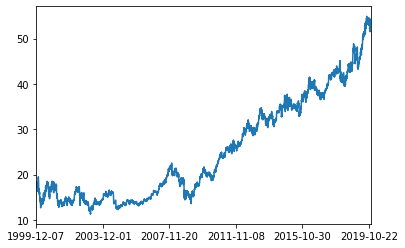

In [14]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

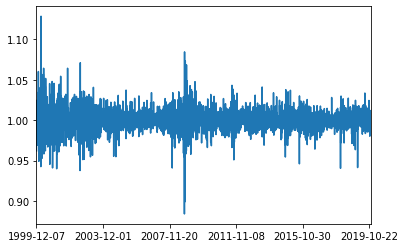

In [15]:
div.sort_index(inplace=True)
div.plot()

In [16]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5032.000000
mean        1.000295
std         0.012504
min         0.883960
1%          0.964267
10%         0.987107
25%         0.994152
50%         1.000521
75%         1.006444
90%         1.013167
95%         1.019121
99%         1.034191
max         1.128634
Name: 0, dtype: float64

In [17]:
div

1999-12-07         NaN
1999-12-08    0.962080
1999-12-09    1.014469
1999-12-10    1.024590
1999-12-13    1.008000
                ...   
2019-12-02    0.992924
2019-12-03    1.007314
2019-12-04    1.001676
2019-12-05    1.007621
2019-12-06    1.001845
Name: 0, Length: 5033, dtype: float64

In [18]:
dateAnnotated = {}

dateAnnotated[2] = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[2], orient='index')
df[0].value_counts()

S    2649
B    2383
Name: 0, dtype: int64

In [19]:
dateAnnotated[8] = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[8], orient='index')
df[0].value_counts()

S0    1120
B0     964
S1     753
B1     683
S2     561
B2     492
B3     244
S3     215
Name: 0, dtype: int64

In [20]:
import pandas as pd

normalizedIndicators = {}
normalizedIndicators[2] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[2])
normalizedIndicators[8] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[8])

data = {}
data[2] = pd.DataFrame.from_dict(normalizedIndicators[2], orient='index')
data[8] = pd.DataFrame.from_dict(normalizedIndicators[8], orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [21]:
data[2] = pd.DataFrame.merge(pd.DataFrame(data[2].indicators.values.tolist(), index=data[2].index), data[2], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
data[8] = pd.DataFrame.merge(pd.DataFrame(data[8].indicators.values.tolist(), index=data[8].index), data[8], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [22]:
data[2].head(), data[8].head()

(                 SMA       EMA      MACD       RSI       ADX       CCI  \
 2019-12-06  0.982997  0.984920  0.003422  0.705788  0.420170  2.385175   
 2019-12-05  0.984229  0.986186  0.002875  0.694555  0.392366  2.140027   
 2019-12-04  0.979646  0.981223  0.002369  0.644463  0.371339  2.561632   
 2019-12-03  0.986628  0.987973  0.001587  0.632558  0.351954  1.909129   
 2019-12-02  0.984902  0.986589  0.001065  0.577367  0.357494  1.664653   
 
                  MOM     WILLR          AD         OBV     ADOSC annotation  
 2019-12-06  0.029287 -0.068658  409.107888  470.855702  3.005105          S  
 2019-12-05  0.027749 -0.113496  227.871693  262.037977  1.668353          S  
 2019-12-04  0.019231 -0.018881  234.648181  269.469166  1.551038          S  
 2019-12-03  0.026405 -0.050199  201.022141  230.913809  1.067989          S  
 2019-12-02  0.019912 -0.000000  240.718868  276.441046  0.966542          B  ,
                  SMA       EMA      MACD       RSI       ADX       CCI  

In [23]:
data[2].annotation = data[2].annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
data[8].annotation = data[8].annotation.apply(lambda x: eight_dict[x])

In [24]:
data[2] = data[2].sort_index()
data[8] = data[8].sort_index()

In [25]:
data[2] = data[2].dropna()
data[8] = data[8].dropna()

In [26]:
len(data[2]), len(data[8])

(5000, 5000)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

data_analysis = pd.DataFrame.merge(data[2], div, left_index=True, right_index=True, how='inner')
X = data_analysis.iloc[:,:8]
y = data_analysis.iloc[:,-1:]

In [28]:
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Specs     Score
5    CCI  1.434117
0    SMA  1.378393
1    EMA  1.352344
3    RSI  1.166768
7  WILLR  1.090984
6    MOM  1.042622
4    ADX  1.037812
2   MACD  0.955661


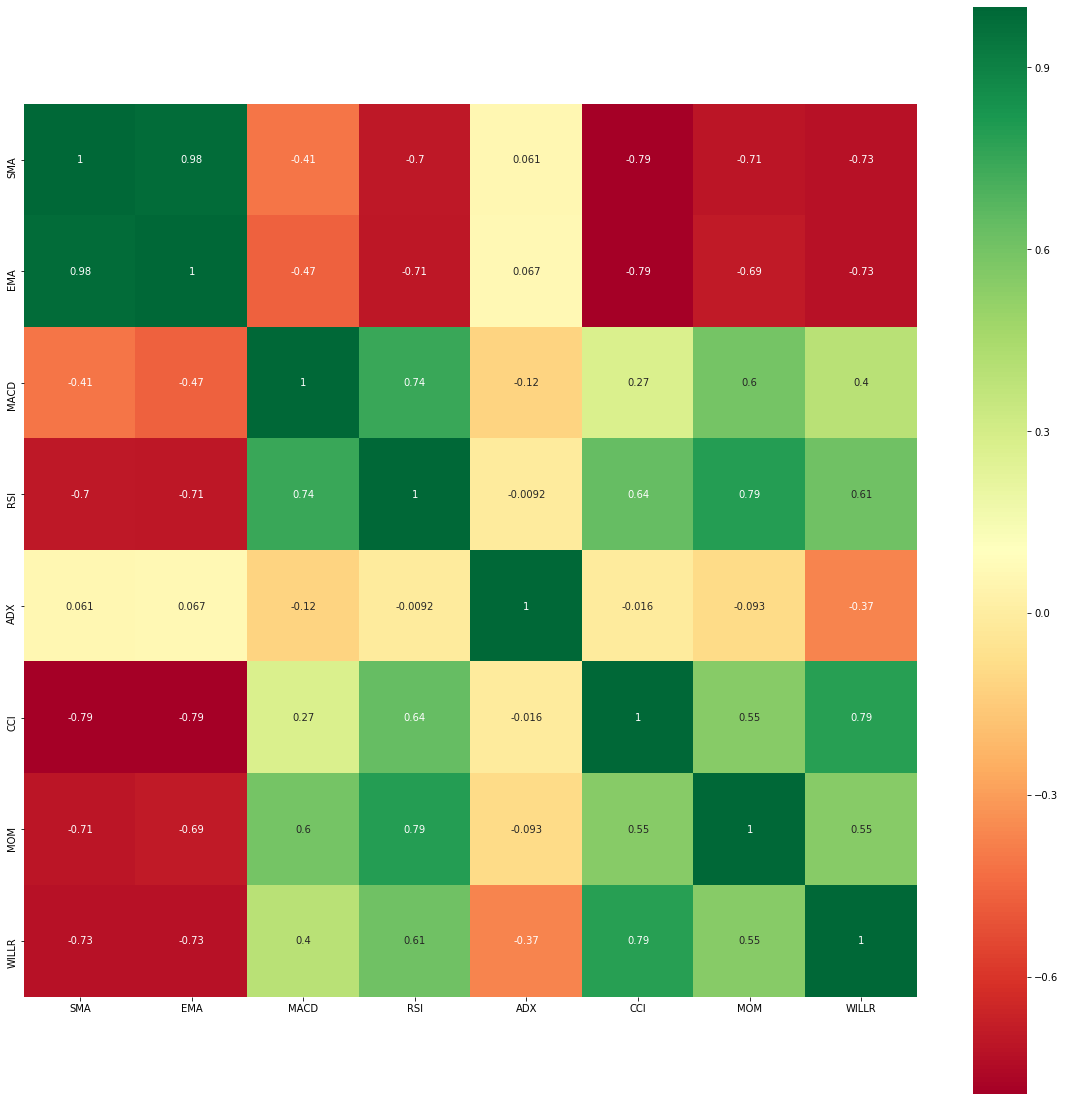

In [29]:
corrmat = data_analysis.iloc[:,:8].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.axis('scaled')
g=sns.heatmap(data_analysis[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
import numpy as np
import matplotlib.pyplot as plt

models = ["mlp","lstm"]
classes = {2: ["S","B"],
           8: ["B3","B2","B1","B0","S0","S1","S2","S3"]}
n_classes = [2, 8]
n_steps = [2,5,10]
n_indicators = [3, 6, 8, 11]
n_indicators_names = {
    3: ['SMA','MOM','WILLR'], 
    6: ['SMA','MOM','WILLR', 'MACD','ADX','RSI'],
    8: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI'],
    11: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI','AD','OBV','ADOSC']
}

batch_size = 32
train_split = .8

# X [d: (all, train, test)] [m: type(mlp/lstm)] [c: classes(2, 8)] [s: n_steps(2,5,10)] [i: indicators(3, 6)] 

In [31]:
X = {}
y = {}
for a in ["all", "train", "test"]:
    X[a] = {}
    y[a] = {}
    for m in models:
        X[a][m] = {}
        y[a][m] = {}
        for c in n_classes:
            X[a][m][c] = {}
            y[a][m][c] = {}
            for s in n_steps:
                X[a][m][c][s] = {}
                y[a][m][c][s] = {}
                for i in n_indicators:
                    X[a][m][c][s][i] = []
                    y[a][m][c][s][i] = []
                    if a == "all":
                        for d in range(len(data[c])):
                            end_ix = d + s
                            if end_ix > len(data[c]):
                                break
                            seq_x, seq_y = data[c].loc[data[c].index.isin(data[c].index[d:end_ix]), n_indicators_names[i]].values, data[c].iloc[end_ix-1, -1]
                            if m == "lstm":
                                X[a][m][c][s][i].append(seq_x)
                            else:
                                X[a][m][c][s][i].append(seq_x.flatten())
                            if c == 2:
                                y[a][m][c][s][i].append(seq_y)
                            else:
                                y[a][m][c][s][i].append(np.eye(c)[seq_y])
                        X[a][m][c][s][i] = np.array(X[a][m][c][s][i])
                        y[a][m][c][s][i] = np.array(y[a][m][c][s][i])

In [32]:
a = 'all'
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(4999, 6) (4999,)
(4999, 12) (4999,)
(4999, 16) (4999,)
(4999, 22) (4999,)
(4996, 15) (4996,)
(4996, 30) (4996,)
(4996, 40) (4996,)
(4996, 55) (4996,)
(4991, 30) (4991,)
(4991, 60) (4991,)
(4991, 80) (4991,)
(4991, 110) (4991,)
(4999, 6) (4999, 8)
(4999, 12) (4999, 8)
(4999, 16) (4999, 8)
(4999, 22) (4999, 8)
(4996, 15) (4996, 8)
(4996, 30) (4996, 8)
(4996, 40) (4996, 8)
(4996, 55) (4996, 8)
(4991, 30) (4991, 8)
(4991, 60) (4991, 8)
(4991, 80) (4991, 8)
(4991, 110) (4991, 8)
(4999, 2, 3) (4999,)
(4999, 2, 6) (4999,)
(4999, 2, 8) (4999,)
(4999, 2, 11) (4999,)
(4996, 5, 3) (4996,)
(4996, 5, 6) (4996,)
(4996, 5, 8) (4996,)
(4996, 5, 11) (4996,)
(4991, 10, 3) (4991,)
(4991, 10, 6) (4991,)
(4991, 10, 8) (4991,)
(4991, 10, 11) (4991,)
(4999, 2, 3) (4999, 8)
(4999, 2, 6) (4999, 8)
(4999, 2, 8) (4999, 8)
(4999, 2, 11) (4999, 8)
(4996, 5, 3) (4996, 8)
(4996, 5, 6) (4996, 8)
(4996, 5, 8) (4996, 8)
(4996, 5, 11) (4996, 8)
(4991, 10, 3) (4991, 8)
(4991, 10, 6) (4991, 8)
(4991, 10, 8) (4991, 8)
(49

In [33]:
data[2].head()

,SMA,EMA,MACD,RSI,ADX,CCI,MOM,WILLR,AD,OBV,ADOSC,annotation
2000-01-25,0.961597,0.963826,0.004315,0.583644,1.808305,2.604470,0.053127,-0.769172,3.085521,3.371206,1.999865,1
2000-01-26,1.009848,1.009099,0.003936,0.593680,1.789919,0.009693,0.052490,-3.217394,0.489457,2.381035,0.511225,0
2000-01-27,1.073328,1.066408,0.002763,0.505881,1.854611,-7.574853,0.030588,-5.026639,0.160433,2.218497,0.298412,1
2000-01-28,1.118072,1.101544,0.001216,0.382209,1.952944,-10.256739,-0.035125,-6.007078,-0.741087,2.580293,-0.139585,1
2000-01-31,1.099843,1.074034,0.000107,0.317803,1.962256,-8.028600,-0.084958,-5.447016,-0.947141,1.614089,-0.448476,1


In [34]:
X["all"]["lstm"][2][5][6][0]

array([[ 9.61596843e-01,  5.31268974e-02, -7.69171857e-01,
         4.31507214e-03,  1.80830506e+00,  5.83643731e-01],
       [ 1.00984776e+00,  5.24896924e-02, -3.21739423e+00,
         3.93570613e-03,  1.78991911e+00,  5.93680041e-01],
       [ 1.07332773e+00,  3.05882353e-02, -5.02663902e+00,
         2.76335913e-03,  1.85461079e+00,  5.05880992e-01],
       [ 1.11807165e+00, -3.51246927e-02, -6.00707821e+00,
         1.21631315e-03,  1.95294423e+00,  3.82208983e-01],
       [ 1.09984331e+00, -8.49582173e-02, -5.44701555e+00,
         1.06990153e-04,  1.96225641e+00,  3.17803173e-01]])

In [35]:
X["all"]["mlp"][2][2][6][0]

array([ 0.96159684,  0.0531269 , -0.76917186,  0.00431507,  1.80830506,
        0.58364373,  1.00984776,  0.05248969, -3.21739423,  0.00393571,
        1.78991911,  0.59368004])

In [36]:
from sklearn.model_selection import train_test_split

for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                if m == "mlp":
                    X['train'][m][c][s][i], X['test'][m][c][s][i], y['train'][m][c][s][i], y['test'][m][c][s][i] = train_test_split(X['all'][m][c][s][i], y['all'][m][c][s][i], train_size=train_split, random_state=0)
                else:
                    X['train'][m][c][s][i] = X['all'][m][c][s][i][:int(len(X['all'][m][c][s][i])*train_split)]
                    X['test'][m][c][s][i] = X['all'][m][c][s][i][int(len(X['all'][m][c][s][i])*train_split):]
                    y['train'][m][c][s][i] = y['all'][m][c][s][i][:int(len(y['all'][m][c][s][i])*train_split)]
                    y['test'][m][c][s][i] = y['all'][m][c][s][i][int(len(y['all'][m][c][s][i])*train_split):]

In [37]:
for a in ['train','test']:
    for m in models:
        for c in n_classes:
            for s in n_steps:
                for i in n_indicators:
                    print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(3999, 6) (3999,)
(3999, 12) (3999,)
(3999, 16) (3999,)
(3999, 22) (3999,)
(3996, 15) (3996,)
(3996, 30) (3996,)
(3996, 40) (3996,)
(3996, 55) (3996,)
(3992, 30) (3992,)
(3992, 60) (3992,)
(3992, 80) (3992,)
(3992, 110) (3992,)
(3999, 6) (3999, 8)
(3999, 12) (3999, 8)
(3999, 16) (3999, 8)
(3999, 22) (3999, 8)
(3996, 15) (3996, 8)
(3996, 30) (3996, 8)
(3996, 40) (3996, 8)
(3996, 55) (3996, 8)
(3992, 30) (3992, 8)
(3992, 60) (3992, 8)
(3992, 80) (3992, 8)
(3992, 110) (3992, 8)
(3999, 2, 3) (3999,)
(3999, 2, 6) (3999,)
(3999, 2, 8) (3999,)
(3999, 2, 11) (3999,)
(3996, 5, 3) (3996,)
(3996, 5, 6) (3996,)
(3996, 5, 8) (3996,)
(3996, 5, 11) (3996,)
(3992, 10, 3) (3992,)
(3992, 10, 6) (3992,)
(3992, 10, 8) (3992,)
(3992, 10, 11) (3992,)
(3999, 2, 3) (3999, 8)
(3999, 2, 6) (3999, 8)
(3999, 2, 8) (3999, 8)
(3999, 2, 11) (3999, 8)
(3996, 5, 3) (3996, 8)
(3996, 5, 6) (3996, 8)
(3996, 5, 8) (3996, 8)
(3996, 5, 11) (3996, 8)
(3992, 10, 3) (3992, 8)
(3992, 10, 6) (3992, 8)
(3992, 10, 8) (3992, 8)
(39

In [38]:
Models = {}
for m in models:
    Models[m] = {}
    for c in n_classes:
        Models[m][c] = {}
        for s in n_steps:
            Models[m][c][s] = {}
            for i in n_indicators:
                Models[m][c][s][i] = {}
                if c == 2:
                    out = 1
                else:
                    out = c
                if m == "mlp":
                    Models[m][c][s][i] = getModelMLP(s, i, out)
                else:
                    Models[m][c][s][i] = getModelBidirectionalLSTM(s, i, out)

In [39]:
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(Models[m][c][s][i])

In [40]:
history = {}
preds = {}
conf = {}
for m in models:
    history[m] = {}
    preds[m] = {}
    conf[m] = {}
    for c in n_classes:
        history[m][c] = {}
        preds[m][c] = {}
        conf[m][c] = {}
        for s in n_steps:
            history[m][c][s] = {}
            preds[m][c][s] = {}
            conf[m][c][s] = {}
            for i in n_indicators:
                history[m][c][s][i] = {}
                preds[m][c][s][i] = {}
                conf[m][c][s][i] = {}

In [76]:
# Calculando lucro/prejuízo total, supondo que inicialmente temos US$1000 em carteira
import copy

def calculateOptimalProfit(preds):
    prices = copy.deepcopy(stockPrices)
    for date in sorted(stockPrices.keys()):
        if len(prices) == len(preds):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}
    
    for date in sorted(prices.keys())[:-1]:
        todayPrice = float(prices[date])
        tomorrowPrice = float(prices[sorted(prices.keys())[index+1]])
        if tomorrowPrice > todayPrice and currentMoney != 0:
            currentStocks = currentMoney/todayPrice
            currentMoney = 0
        elif tomorrowPrice < todayPrice and currentStocks != 0:
            currentMoney = currentStocks*todayPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*todayPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney
        
    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()

def calculateProfit(preds):
    
    if any(item in list(np.argmax(preds, axis=1)) for item in [2, 3, 4, 5, 6, 7]):
        classificationArray = list(np.argmax(preds, axis=1))
    else:
        classificationArray = []
        for predValue in preds:
            if predValue < 0.5:
                classificationArray.append(0)
            else:
                classificationArray.append(1)
    
    print(classificationArray)
    if (max(classificationArray) == 1):
        buyClassification = [0]
        sellClassification = [1]
        print("Using simple buy/sell (2 classes) classification")
    else:
        buyClassification = [0, 1, 2, 3]
        sellClassification = [4, 5, 6, 7]
        print("Using complex buy/sell (8 classes) classification")

    prices = copy.deepcopy(stockPrices)

    for date in sorted(stockPrices.keys()):
        if len(prices) == len(classificationArray):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}

    for date in sorted(prices.keys()):
        stockPrice = float(prices[date])
        classification = classificationArray[index]
        if currentMoney != 0 and classification in buyClassification:
            currentStocks = currentMoney/stockPrice
            currentMoney = 0.0
        elif currentStocks != 0 and classification in sellClassification:
            currentMoney = currentStocks*stockPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*stockPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney

    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
#     moneyGrowthPerYear = (finalMoney-initialMoney)/timeLenInYears
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)

#     print("[DEBUG] Current money:\t   US$ " + str(round(currentMoney, 2)))
#     print("[DEBUG] Current stocks:\t   " + str(round(currentStocks, 2)) + "\t| Last stock-price: US$ " + str(round(lastPrice, 2)))
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()
#     pricesDf = pd.DataFrame.from_dict(prices, orient='index')
#     pricesDf.sort_index(inplace=True)
#     pricesDf[0].astype('float').plot(ax=graphAx)

In [42]:
def fit(m, c, s, i):
    history[m][c][s][i] = Models[m][c][s][i].fit(
        X['train'][m][c][s][i], 
        y['train'][m][c][s][i], 
        epochs=300, 
        verbose=1,
        batch_size=batch_size)
    plt.plot(history[m][c][s][i].history['loss'], label='train')
#     plt.plot(history[m][c][s][i].history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(m, c, s, i):
    preds[m][c][s][i] = Models[m][c][s][i].predict(
        X['test'][m][c][s][i], 
        batch_size=batch_size)
    print(f"Model {m}\nNumber of classes {c}\nNumber of steps {s}\nNumber of indicators {i}")
    print(classification_report(y['test'][m][c][s][i], 
                                np.rint(preds[m][c][s][i]).astype(np.int64), 
                                target_names=classes[c], 
                                digits=5))
    if c == 2:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i], 
                                                 np.rint(preds[m][c][s][i]).astype(np.int64), 
                                                 classes=np.array(classes[c]))
    else:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i].argmax(axis=1), 
                                                 np.rint(preds[m][c][s][i]).argmax(axis=1), 
                                                 classes=np.array(classes[c]))
        
def get_next_value(m, c, s, i):
    i = n_indicators[(n_indicators.index(i) + 1)%len(n_indicators)]
    if (n_indicators.index(i) == 0):
        s = n_steps[(n_steps.index(s) + 1)%len(n_steps)]
        if (n_steps.index(s) == 0):
            c = n_classes[(n_classes.index(c) + 1)%len(n_classes)]
            if (n_classes.index(c) == 0):
                m = models[(models.index(m) + 1)%len(models)]    
    return m, c, s, i

In [43]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

for x in range(48):
    Models[m][c][s][i].summary()
    m, c, s, i = get_next_value(m, c, s, i)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Outpu

Epoch 1/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.7460 - accuracy: 0.5006
Epoch 2/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.6928 - accuracy: 0.51510s - loss: 0.6938 - accuracy: 0.51
Epoch 3/300
3999/3999 [==============================] - 0s 95us/step - loss: 0.6693 - accuracy: 0.5821
Epoch 4/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.6598 - accuracy: 0.6072
Epoch 5/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.6542 - accuracy: 0.6182
Epoch 6/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6499 - accuracy: 0.6249
Epoch 7/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.6477 - accuracy: 0.6272
Epoch 8/300
3999/3999 [==============================] - 0s 94us/step - loss: 0.6470 - accuracy: 0.6307
Epoch 9/300
3999/3999 [==============================] - 0s 91us/step - loss: 0.6475 - accuracy: 0.6319
Epoch 10/300
3999/3999 [==

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 277us/step - loss: 0.5940 - accuracy: 0.6857
Epoch 71/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.5905 - accuracy: 0.6844
Epoch 72/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.5829 - accuracy: 0.6884
Epoch 73/300
3999/3999 [==============================] - 1s 151us/step - loss: 0.5847 - accuracy: 0.6927
Epoch 74/300
3999/3999 [==============================] - 1s 144us/step - loss: 0.5787 - accuracy: 0.6907
Epoch 75/300
3999/3999 [==============================] - 1s 219us/step - loss: 0.5801 - accuracy: 0.6892
Epoch 76/300
3999/3999 [==============================] - 1s 139us/step - loss: 0.5731 - accuracy: 0.6987
Epoch 77/300
3999/3999 [==============================] - 1s 222us/step - loss: 0.5698 - accuracy: 0.6954
Epoch 78/300
3999/3999 [==============================] - 1s 150us/step - loss: 0.5712 - accuracy: 0.7042
Epoch 79/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 0s 102us/step - loss: 0.5250 - accuracy: 0.7464
Epoch 145/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.5168 - accuracy: 0.7554
Epoch 146/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.5294 - accuracy: 0.7414
Epoch 147/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.5297 - accuracy: 0.7464
Epoch 148/300
3999/3999 [==============================] - 1s 149us/step - loss: 0.5191 - accuracy: 0.7517
Epoch 149/300
3999/3999 [==============================] - 1s 179us/step - loss: 0.5218 - accuracy: 0.7452
Epoch 150/300
3999/3999 [==============================] - 0s 124us/step - loss: 0.5269 - accuracy: 0.7472
Epoch 151/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.5246 - accuracy: 0.7489
Epoch 152/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.5215 - accuracy: 0.7559
Epoch 153/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 162us/step - loss: 0.5212 - accuracy: 0.7547
Epoch 220/300
3999/3999 [==============================] - 1s 135us/step - loss: 0.5159 - accuracy: 0.7544
Epoch 221/300
3999/3999 [==============================] - 1s 175us/step - loss: 0.5246 - accuracy: 0.7527
Epoch 222/300
3999/3999 [==============================] - 1s 130us/step - loss: 0.5327 - accuracy: 0.7467
Epoch 223/300
3999/3999 [==============================] - 1s 196us/step - loss: 0.5211 - accuracy: 0.7537
Epoch 224/300
3999/3999 [==============================] - 1s 145us/step - loss: 0.5243 - accuracy: 0.7524
Epoch 225/300
3999/3999 [==============================] - 1s 176us/step - loss: 0.5184 - accuracy: 0.7492
Epoch 226/300
3999/3999 [==============================] - 1s 161us/step - loss: 0.5153 - accuracy: 0.7514
Epoch 227/300
3999/3999 [==============================] - 1s 147us/step - loss: 0.5236 - accuracy: 0.7549
Epoch 228/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 140us/step - loss: 0.5159 - accuracy: 0.7517
Epoch 294/300
3999/3999 [==============================] - 1s 154us/step - loss: 0.5236 - accuracy: 0.7502
Epoch 295/300
3999/3999 [==============================] - 1s 168us/step - loss: 0.5204 - accuracy: 0.7534
Epoch 296/300
3999/3999 [==============================] - 0s 123us/step - loss: 0.5207 - accuracy: 0.7597
Epoch 297/300
3999/3999 [==============================] - 1s 152us/step - loss: 0.5229 - accuracy: 0.7489
Epoch 298/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.5160 - accuracy: 0.7539
Epoch 299/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.5233 - accuracy: 0.7534
Epoch 300/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.5186 - accuracy: 0.7557


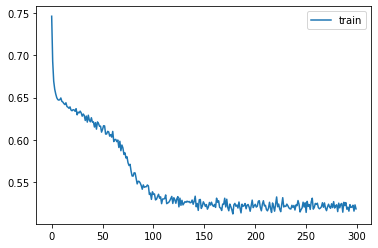

In [44]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.75797   0.78295   0.77026       516
           B    0.76017   0.73347   0.74658       484

    accuracy                        0.75900      1000
   macro avg    0.75907   0.75821   0.75842      1000
weighted avg    0.75904   0.75900   0.75880      1000

Confusion matrix, without normalization
[[404 112]
 [129 355]]


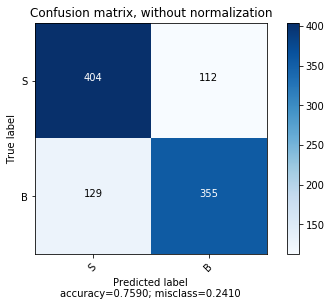

[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 

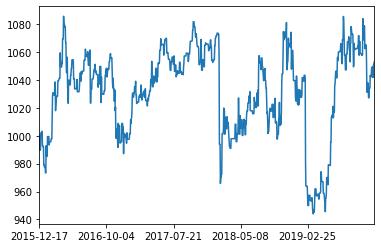

In [45]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 564us/step - loss: 0.6675 - accuracy: 0.6059
Epoch 2/300
3999/3999 [==============================] - 1s 277us/step - loss: 0.6403 - accuracy: 0.6307
Epoch 3/300
3999/3999 [==============================] - 1s 155us/step - loss: 0.6319 - accuracy: 0.6447
Epoch 4/300
3999/3999 [==============================] - 1s 210us/step - loss: 0.6265 - accuracy: 0.64890s - loss: 0.6281 - ac - ETA: 0s - loss: 0.6271 - accuracy
Epoch 5/300
3999/3999 [==============================] - 1s 210us/step - loss: 0.6225 - accuracy: 0.6594
Epoch 6/300
3999/3999 [==============================] - 1s 170us/step - loss: 0.6071 - accuracy: 0.6792
Epoch 7/300
3999/3999 [==============================] - 1s 216us/step - loss: 0.5966 - accuracy: 0.6882
Epoch 8/300
3999/3999 [==============================] - 1s 187us/step - loss: 0.5829 - accuracy: 0.7007
Epoch 9/300
3999/3999 [==============================] - 1s 169us/step - loss: 0.5540 - accuracy: 0.72

3999/3999 [==============================] - 2s 416us/step - loss: 0.1709 - accuracy: 0.9267
Epoch 76/300
3999/3999 [==============================] - 1s 367us/step - loss: 0.1425 - accuracy: 0.9427
Epoch 77/300
3999/3999 [==============================] - 2s 401us/step - loss: 0.1308 - accuracy: 0.9502
Epoch 78/300
1312/3999 [========>.....................] - ETA: 0s - loss: 0.1604 - accuracy: 0.9276

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 282us/step - loss: 0.1379 - accuracy: 0.9392
Epoch 79/300
3999/3999 [==============================] - 1s 275us/step - loss: 0.1289 - accuracy: 0.9487
Epoch 80/300
3999/3999 [==============================] - 2s 388us/step - loss: 0.1510 - accuracy: 0.93770s - loss: 0.1500 - accuracy: 0.
Epoch 81/300
3999/3999 [==============================] - 1s 323us/step - loss: 0.1508 - accuracy: 0.9412
Epoch 82/300
3999/3999 [==============================] - 1s 361us/step - loss: 0.1314 - accuracy: 0.9477
Epoch 83/300
3999/3999 [==============================] - 1s 340us/step - loss: 0.1403 - accuracy: 0.9450
Epoch 84/300
3999/3999 [==============================] - 2s 408us/step - loss: 0.1434 - accuracy: 0.9425
Epoch 85/300
3999/3999 [==============================] - 1s 315us/step - loss: 0.1230 - accuracy: 0.9510
Epoch 86/300
3999/3999 [==============================] - 1s 368us/step - loss: 0.1198 - accuracy: 0.9497
Epoch 87/300
3999/3999 [===

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 359us/step - loss: 0.1184 - accuracy: 0.9465
Epoch 133/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.1115 - accuracy: 0.9525
Epoch 134/300
3999/3999 [==============================] - 1s 281us/step - loss: 0.1018 - accuracy: 0.9595
Epoch 135/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.0971 - accuracy: 0.9592
Epoch 136/300
3999/3999 [==============================] - 1s 302us/step - loss: 0.1113 - accuracy: 0.9552
Epoch 137/300
3999/3999 [==============================] - 1s 333us/step - loss: 0.1103 - accuracy: 0.9530
Epoch 138/300
3999/3999 [==============================] - 1s 274us/step - loss: 0.0997 - accuracy: 0.9587
Epoch 139/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.1127 - accuracy: 0.9527
Epoch 140/300
3999/3999 [==============================] - 1s 288us/step - loss: 0.1015 - accuracy: 0.9560
Epoch 141/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 334us/step - loss: 0.1212 - accuracy: 0.9475
Epoch 157/300
3999/3999 [==============================] - 1s 333us/step - loss: 0.1052 - accuracy: 0.9560
Epoch 158/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.1102 - accuracy: 0.9537
Epoch 159/300
3999/3999 [==============================] - 1s 320us/step - loss: 0.1000 - accuracy: 0.9587
Epoch 160/300
3999/3999 [==============================] - 1s 322us/step - loss: 0.1002 - accuracy: 0.9597
Epoch 161/300
3999/3999 [==============================] - 1s 329us/step - loss: 0.1020 - accuracy: 0.95972s - l
Epoch 162/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.1328 - accuracy: 0.9470
Epoch 163/300
3999/3999 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - 1s 353us/step - loss: 0.0991 - accuracy: 0.9632
Epoch 164/300
3999/3999 [==============================] - 1s 336us/step - loss: 0.1039 - accuracy: 0.95920s -

3999/3999 [==============================] - 0s 104us/step - loss: 0.1053 - accuracy: 0.9572
Epoch 231/300
3999/3999 [==============================] - 1s 131us/step - loss: 0.0976 - accuracy: 0.9595
Epoch 232/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.1019 - accuracy: 0.9580
Epoch 233/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.0945 - accuracy: 0.9632
Epoch 234/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.1064 - accuracy: 0.9580
Epoch 235/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.1039 - accuracy: 0.9582
Epoch 236/300
3999/3999 [==============================] - 1s 144us/step - loss: 0.0804 - accuracy: 0.9692
Epoch 237/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.0824 - accuracy: 0.9670
Epoch 238/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1043 - accuracy: 0.9590
Epoch 239/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 166us/step - loss: 0.1108 - accuracy: 0.9585
Epoch 260/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.1023 - accuracy: 0.9605
Epoch 261/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.1031 - accuracy: 0.9565
Epoch 262/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.0845 - accuracy: 0.9647
Epoch 263/300
3999/3999 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - 1s 168us/step - loss: 0.0965 - accuracy: 0.9605
Epoch 264/300
3999/3999 [==============================] - 1s 141us/step - loss: 0.1100 - accuracy: 0.9530
Epoch 265/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.1120 - accuracy: 0.9567
Epoch 266/300
3999/3999 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - 0s 124us/step - loss: 0.0874 - accuracy: 0.9647
Epoch 267/300
3999/3999 [==============================] - 0s 118us/step -

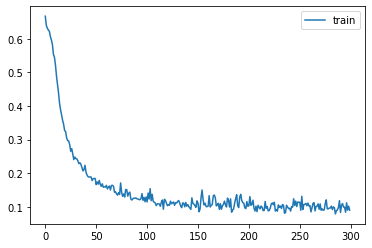

In [46]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.99589   0.93992   0.96710       516
           B    0.93957   0.99587   0.96690       484

    accuracy                        0.96700      1000
   macro avg    0.96773   0.96790   0.96700      1000
weighted avg    0.96863   0.96700   0.96700      1000

Confusion matrix, without normalization
[[485  31]
 [  2 482]]


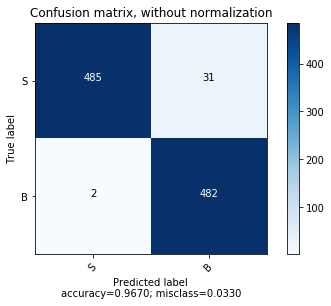

[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 

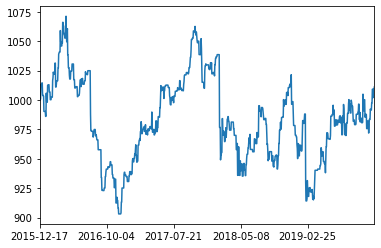

In [47]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 347us/step - loss: 0.6281 - accuracy: 0.6717
Epoch 2/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.5625 - accuracy: 0.7137
Epoch 3/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.5458 - accuracy: 0.7279
Epoch 4/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.5351 - accuracy: 0.7422
Epoch 5/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.5225 - accuracy: 0.7542
Epoch 6/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.5078 - accuracy: 0.7604
Epoch 7/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.4966 - accuracy: 0.7662
Epoch 8/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.4961 - accuracy: 0.7669
Epoch 9/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.4855 - accuracy: 0.7812
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 1s 148us/step - loss: 0.2065 - accuracy: 0.9175
Epoch 79/300
3999/3999 [==============================] - 1s 165us/step - loss: 0.2021 - accuracy: 0.91350s - loss: 0.1771 - accuracy: 0. - ETA: 1s - loss: 0.182
Epoch 80/300
3999/3999 [==============================] - 1s 168us/step - loss: 0.2090 - accuracy: 0.9107
Epoch 81/300
3999/3999 [==============================] - 1s 162us/step - loss: 0.2028 - accuracy: 0.91850s - loss: 0.1997 
Epoch 82/300
3999/3999 [==============================] - 1s 140us/step - loss: 0.2092 - accuracy: 0.9130
Epoch 83/300
3999/3999 [==============================] - 0s 124us/step - loss: 0.1973 - accuracy: 0.9202
Epoch 84/300
3999/3999 [==============================] - 1s 146us/step - loss: 0.2194 - accuracy: 0.9082
Epoch 85/300
3999/3999 [==============================] - 1s 127us/step - loss: 0.2033 - accuracy: 0.9182
Epoch 86/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.2126 - ac

3999/3999 [==============================] - 0s 108us/step - loss: 0.1500 - accuracy: 0.9375
Epoch 154/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.1451 - accuracy: 0.9430
Epoch 155/300
3999/3999 [==============================] - 0s 124us/step - loss: 0.1425 - accuracy: 0.9412
Epoch 156/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.1564 - accuracy: 0.9350
Epoch 157/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.1542 - accuracy: 0.9335
Epoch 158/300
3999/3999 [==============================] - 1s 153us/step - loss: 0.1557 - accuracy: 0.9390
Epoch 159/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.1294 - accuracy: 0.9500
Epoch 160/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.1485 - accuracy: 0.9400
Epoch 161/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1418 - accuracy: 0.9412
Epoch 162/300
3999/3999 [==========================

3999/3999 [==============================] - 0s 110us/step - loss: 0.1074 - accuracy: 0.9545
Epoch 230/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.1205 - accuracy: 0.9500
Epoch 231/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.1302 - accuracy: 0.9497
Epoch 232/300
3999/3999 [==============================] - 0s 123us/step - loss: 0.1336 - accuracy: 0.9507
Epoch 233/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.1392 - accuracy: 0.9407
Epoch 234/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.1506 - accuracy: 0.9367
Epoch 235/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.1362 - accuracy: 0.9427
Epoch 236/300
3999/3999 [==============================] - 0s 125us/step - loss: 0.1142 - accuracy: 0.9542
Epoch 237/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.1135 - accuracy: 0.9527
Epoch 238/300
3999/3999 [==========================

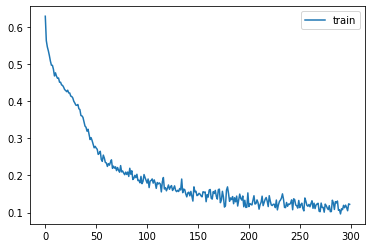

In [48]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.93727   0.98450   0.96030       516
           B    0.98253   0.92975   0.95541       484

    accuracy                        0.95800      1000
   macro avg    0.95990   0.95712   0.95786      1000
weighted avg    0.95918   0.95800   0.95794      1000

Confusion matrix, without normalization
[[508   8]
 [ 34 450]]


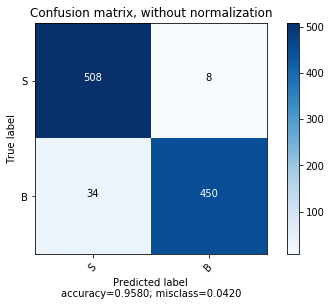

[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 

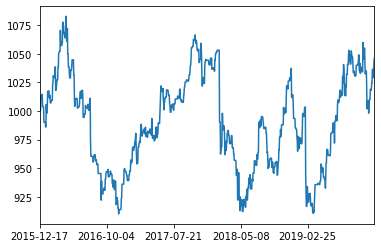

In [49]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 372us/step - loss: 3.7938 - accuracy: 0.5086
Epoch 2/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.8038 - accuracy: 0.5324
Epoch 3/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.7324 - accuracy: 0.5489
Epoch 4/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.7303 - accuracy: 0.5536
Epoch 5/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.7000 - accuracy: 0.5601
Epoch 6/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.6996 - accuracy: 0.5596
Epoch 7/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.6929 - accuracy: 0.5641
Epoch 8/300
3999/3999 [==============================] - 1s 135us/step - loss: 0.6890 - accuracy: 0.5539
Epoch 9/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.6844 - accuracy: 0.5711
Epoch 10/300
3999/3999 [==============================] 

3999/3999 [==============================] - 0s 104us/step - loss: 0.5462 - accuracy: 0.7279
Epoch 78/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.5374 - accuracy: 0.7297
Epoch 79/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.5392 - accuracy: 0.7342
Epoch 80/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.5432 - accuracy: 0.7259
Epoch 81/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.5394 - accuracy: 0.7279
Epoch 82/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.5344 - accuracy: 0.7384
Epoch 83/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.5363 - accuracy: 0.7357
Epoch 84/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.5431 - accuracy: 0.7324
Epoch 85/300
3999/3999 [==============================] - 1s 131us/step - loss: 0.5335 - accuracy: 0.7354
Epoch 86/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 0s 116us/step - loss: 0.4809 - accuracy: 0.7714
Epoch 154/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.4936 - accuracy: 0.7584
Epoch 155/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.4729 - accuracy: 0.7759
Epoch 156/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.4773 - accuracy: 0.7689
Epoch 157/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.4861 - accuracy: 0.7607
Epoch 158/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.4821 - accuracy: 0.7614
Epoch 159/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.4778 - accuracy: 0.7744
Epoch 160/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.4704 - accuracy: 0.7752
Epoch 161/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.4573 - accuracy: 0.7919
Epoch 162/300
3999/3999 [==========================

3999/3999 [==============================] - 0s 110us/step - loss: 0.4516 - accuracy: 0.7844
Epoch 230/300
3999/3999 [==============================] - 1s 138us/step - loss: 0.4475 - accuracy: 0.7922
Epoch 231/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.4664 - accuracy: 0.7814
Epoch 232/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.4593 - accuracy: 0.7884
Epoch 233/300
3999/3999 [==============================] - 0s 105us/step - loss: 0.4652 - accuracy: 0.78040s - loss: 0.4608 - accuracy: 
Epoch 234/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.4412 - accuracy: 0.7939
Epoch 235/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.4583 - accuracy: 0.7799
Epoch 236/300
3999/3999 [==============================] - 1s 141us/step - loss: 0.4597 - accuracy: 0.7869
Epoch 237/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.4542 - accuracy: 0.7872
Epoch 238/300
3999/39

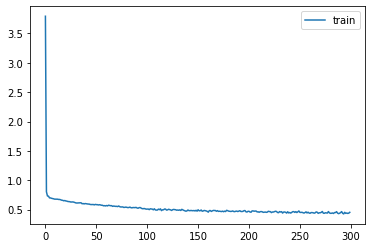

In [50]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.74593   0.88760   0.81062       516
           B    0.84974   0.67769   0.75402       484

    accuracy                        0.78600      1000
   macro avg    0.79783   0.78264   0.78232      1000
weighted avg    0.79617   0.78600   0.78323      1000

Confusion matrix, without normalization
[[458  58]
 [156 328]]


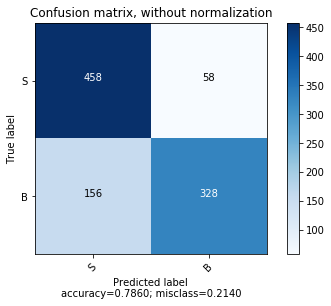

First date:	   2015-12-18	| Initial stock value: US$ 38.460434245351216
Last date:	   2019-12-06	| Final stock value: US$ 54.31
Stock value growth:	41.21%
[DEBUG] Initial money:    US$ 1000.0 | Final money: US$ 27247.29
[DEBUG] Final profit:	   US$ 26247.29 over 3.97 years
Money growth:      	2624.73%
Growth per year:   	129.99%
[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,

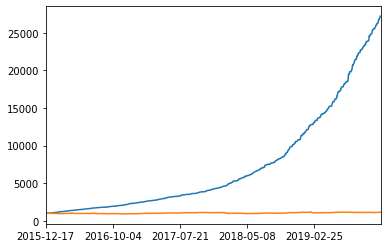

In [51]:
predict(m, c, s, i)
calculateOptimalProfit(preds[m][c][s][i])
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 395us/step - loss: 0.6097 - accuracy: 0.6739
Epoch 2/300
3996/3996 [==============================] - 1s 133us/step - loss: 0.5548 - accuracy: 0.7237
Epoch 3/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.5394 - accuracy: 0.7415
Epoch 4/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.5283 - accuracy: 0.7462
Epoch 5/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.5303 - accuracy: 0.7442
Epoch 6/300
3996/3996 [==============================] - 1s 126us/step - loss: 0.5286 - accuracy: 0.7535
Epoch 7/300
3996/3996 [==============================] - 1s 154us/step - loss: 0.5213 - accuracy: 0.7492
Epoch 8/300
3996/3996 [==============================] - 0s 124us/step - loss: 0.5224 - accuracy: 0.7553
Epoch 9/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.5171 - accuracy: 0.7523
Epoch 10/300
3996/3996 [==============================]

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 180us/step - loss: 0.4786 - accuracy: 0.7758
Epoch 67/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.4826 - accuracy: 0.7715
Epoch 68/300
3996/3996 [==============================] - 1s 145us/step - loss: 0.4856 - accuracy: 0.7705
Epoch 69/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.4819 - accuracy: 0.7785
Epoch 70/300
3996/3996 [==============================] - 1s 134us/step - loss: 0.4869 - accuracy: 0.7728
Epoch 71/300
3996/3996 [==============================] - 0s 120us/step - loss: 0.4820 - accuracy: 0.7683
Epoch 72/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.4817 - accuracy: 0.77330s - loss: 0.4848 - accura
Epoch 73/300
3996/3996 [==============================] - 1s 129us/step - loss: 0.4812 - accuracy: 0.7725
Epoch 74/300
3996/3996 [==============================] - 1s 143us/step - loss: 0.4813 - accuracy: 0.7773
Epoch 75/300
3996/3996 [=========

3996/3996 [==============================] - 1s 142us/step - loss: 0.4491 - accuracy: 0.7910
Epoch 142/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4544 - accuracy: 0.7870
Epoch 143/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.4580 - accuracy: 0.7848
Epoch 144/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4519 - accuracy: 0.7898
Epoch 145/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.4626 - accuracy: 0.7843
Epoch 146/300
3996/3996 [==============================] - 1s 126us/step - loss: 0.4542 - accuracy: 0.7890
Epoch 147/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4514 - accuracy: 0.7895
Epoch 148/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4542 - accuracy: 0.79080s - loss: 0.4577 - accuracy: 
Epoch 149/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.4531 - accuracy: 0.7915
Epoch 150/300
3996/39

3996/3996 [==============================] - 0s 102us/step - loss: 0.4453 - accuracy: 0.7960
Epoch 217/300
3996/3996 [==============================] - 0s 103us/step - loss: 0.4430 - accuracy: 0.7935
Epoch 218/300
3996/3996 [==============================] - 0s 91us/step - loss: 0.4498 - accuracy: 0.7915
Epoch 219/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.4373 - accuracy: 0.7950
Epoch 220/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4443 - accuracy: 0.7928
Epoch 221/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.4368 - accuracy: 0.7968
Epoch 222/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.4473 - accuracy: 0.7903
Epoch 223/300
3996/3996 [==============================] - 1s 142us/step - loss: 0.4407 - accuracy: 0.7973
Epoch 224/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.4423 - accuracy: 0.7963
Epoch 225/300
3996/3996 [===========================

3996/3996 [==============================] - 0s 113us/step - loss: 0.4333 - accuracy: 0.7978
Epoch 293/300
3996/3996 [==============================] - 1s 129us/step - loss: 0.4366 - accuracy: 0.7943
Epoch 294/300
3996/3996 [==============================] - 0s 94us/step - loss: 0.4359 - accuracy: 0.7948
Epoch 295/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.4373 - accuracy: 0.7995
Epoch 296/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.4373 - accuracy: 0.8026
Epoch 297/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.4322 - accuracy: 0.7980
Epoch 298/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4284 - accuracy: 0.8016
Epoch 299/300
3996/3996 [==============================] - 0s 92us/step - loss: 0.4423 - accuracy: 0.7968
Epoch 300/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4356 - accuracy: 0.7983


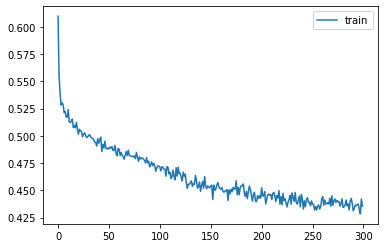

In [52]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.82460   0.78503   0.80433       521
           B    0.77778   0.81837   0.79756       479

    accuracy                        0.80100      1000
   macro avg    0.80119   0.80170   0.80094      1000
weighted avg    0.80217   0.80100   0.80108      1000

Confusion matrix, without normalization
[[409 112]
 [ 87 392]]


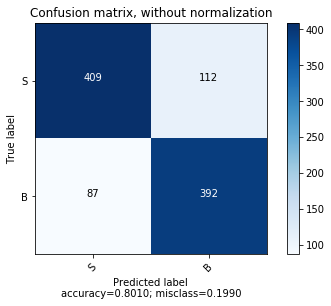

[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

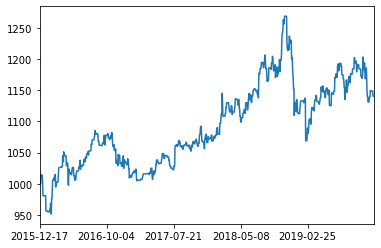

In [53]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 354us/step - loss: 0.6112 - accuracy: 0.6732
Epoch 2/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.5395 - accuracy: 0.7347
Epoch 3/300
3996/3996 [==============================] - 0s 118us/step - loss: 0.5236 - accuracy: 0.7580
Epoch 4/300
3996/3996 [==============================] - 0s 103us/step - loss: 0.5123 - accuracy: 0.7550
Epoch 5/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.4950 - accuracy: 0.7698
Epoch 6/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.4960 - accuracy: 0.7675
Epoch 7/300
3996/3996 [==============================] - 0s 105us/step - loss: 0.4981 - accuracy: 0.7683
Epoch 8/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.4799 - accuracy: 0.7805
Epoch 9/300
3996/3996 [==============================] - 0s 120us/step - loss: 0.4898 - accuracy: 0.7723
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 122us/step - loss: 0.2102 - accuracy: 0.9109
Epoch 79/300
3996/3996 [==============================] - 0s 122us/step - loss: 0.2247 - accuracy: 0.9022
Epoch 80/300
3996/3996 [==============================] - 1s 135us/step - loss: 0.2326 - accuracy: 0.9034
Epoch 81/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.2206 - accuracy: 0.9047
Epoch 82/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.2112 - accuracy: 0.9084
Epoch 83/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.2081 - accuracy: 0.9142
Epoch 84/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.2051 - accuracy: 0.9132
Epoch 85/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.2022 - accuracy: 0.9154
Epoch 86/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.2212 - accuracy: 0.9082
Epoch 87/300
3996/3996 [==============================] - 0

3996/3996 [==============================] - 0s 108us/step - loss: 0.1685 - accuracy: 0.9282
Epoch 153/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.1598 - accuracy: 0.9364
Epoch 154/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.1636 - accuracy: 0.9362
Epoch 155/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.1759 - accuracy: 0.9287
Epoch 156/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.1710 - accuracy: 0.9247
Epoch 157/300
3996/3996 [==============================] - 1s 142us/step - loss: 0.1904 - accuracy: 0.9177
Epoch 158/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.1817 - accuracy: 0.9239
Epoch 159/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.2082 - accuracy: 0.9089
Epoch 160/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.2265 - accuracy: 0.9039
Epoch 161/300
3996/3996 [==========================

3996/3996 [==============================] - 2s 385us/step - loss: 0.1562 - accuracy: 0.9387
Epoch 228/300
3996/3996 [==============================] - 1s 268us/step - loss: 0.1614 - accuracy: 0.93440s - loss: 0.1715 
Epoch 229/300
 704/3996 [====>.........................] - ETA: 1s - loss: 0.1701 - accuracy: 0.9361

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 352us/step - loss: 0.1786 - accuracy: 0.92670s - loss: 0.1782 - 
Epoch 230/300
3996/3996 [==============================] - 1s 293us/step - loss: 0.1889 - accuracy: 0.91570s - loss: 0.1981 - accuracy:  - ETA: 0s - loss: 0.1929 - accuracy: 
Epoch 231/300
3996/3996 [==============================] - 1s 362us/step - loss: 0.1689 - accuracy: 0.9307
Epoch 232/300
3996/3996 [==============================] - 1s 321us/step - loss: 0.1872 - accuracy: 0.9177
Epoch 233/300
3996/3996 [==============================] - 1s 312us/step - loss: 0.1597 - accuracy: 0.9324
Epoch 234/300
3996/3996 [==============================] - 1s 307us/step - loss: 0.1531 - accuracy: 0.93490s - l
Epoch 235/300
3996/3996 [==============================] - 1s 303us/step - loss: 0.1492 - accuracy: 0.9387
Epoch 236/300
3996/3996 [==============================] - 1s 257us/step - loss: 0.1473 - accuracy: 0.93770s - l
Epoch 237/300
3996/3996 [==============================] -

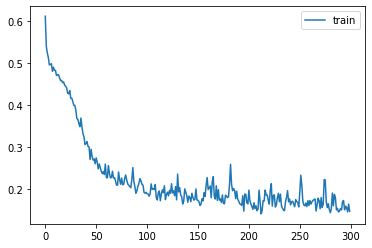

In [54]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.83360   1.00000   0.90925       521
           B    1.00000   0.78288   0.87822       479

    accuracy                        0.89600      1000
   macro avg    0.91680   0.89144   0.89373      1000
weighted avg    0.91331   0.89600   0.89439      1000

Confusion matrix, without normalization
[[521   0]
 [104 375]]


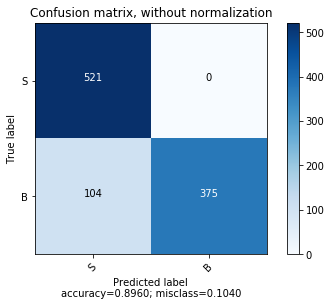

[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 

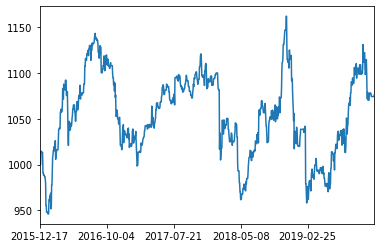

In [55]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.5951 - accuracy: 0.7057
Epoch 2/300
3996/3996 [==============================] - 1s 255us/step - loss: 0.5294 - accuracy: 0.7495
Epoch 3/300
3996/3996 [==============================] - 1s 251us/step - loss: 0.5112 - accuracy: 0.75780s - loss: 0.5176 - 
Epoch 4/300
3996/3996 [==============================] - 1s 246us/step - loss: 0.4980 - accuracy: 0.77250s - loss: 0.5003 - accuracy: 
Epoch 5/300
3996/3996 [==============================] - 1s 244us/step - loss: 0.4819 - accuracy: 0.7783
Epoch 6/300
3996/3996 [==============================] - 1s 252us/step - loss: 0.4728 - accuracy: 0.7788
Epoch 7/300
3996/3996 [==============================] - 1s 226us/step - loss: 0.4744 - accuracy: 0.7833
Epoch 8/300
3996/3996 [==============================] - 1s 208us/step - loss: 0.4633 - accuracy: 0.7870
Epoch 9/300
3996/3996 [==============================] - 1s 251us/step - loss: 0.4564 - accuracy: 0.7900
Epoch 1

3996/3996 [==============================] - 1s 239us/step - loss: 0.3462 - accuracy: 0.8463
Epoch 76/300
3996/3996 [==============================] - 1s 224us/step - loss: 0.3407 - accuracy: 0.8476
Epoch 77/300
3996/3996 [==============================] - 1s 262us/step - loss: 0.3320 - accuracy: 0.85641s - loss: 0
Epoch 78/300
3996/3996 [==============================] - 1s 203us/step - loss: 0.3374 - accuracy: 0.8498
Epoch 79/300
3996/3996 [==============================] - 1s 175us/step - loss: 0.3242 - accuracy: 0.8619
Epoch 80/300
3996/3996 [==============================] - 1s 180us/step - loss: 0.3261 - accuracy: 0.8621
Epoch 81/300
3996/3996 [==============================] - 1s 271us/step - loss: 0.3255 - accuracy: 0.8539
Epoch 82/300
3996/3996 [==============================] - 1s 263us/step - loss: 0.3281 - accuracy: 0.8539
Epoch 83/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.3286 - accuracy: 0.8641
Epoch 84/300
3996/3996 [=======================

3996/3996 [==============================] - 1s 132us/step - loss: 0.2287 - accuracy: 0.9049
Epoch 151/300
3996/3996 [==============================] - 0s 124us/step - loss: 0.2282 - accuracy: 0.9077
Epoch 152/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.2432 - accuracy: 0.9012
Epoch 153/300
3996/3996 [==============================] - 0s 120us/step - loss: 0.2371 - accuracy: 0.8924
Epoch 154/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.2252 - accuracy: 0.9012
Epoch 155/300
3996/3996 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.90 - 0s 115us/step - loss: 0.2383 - accuracy: 0.8984
Epoch 156/300
3996/3996 [==============================] - 1s 241us/step - loss: 0.2266 - accuracy: 0.9039
Epoch 157/300
3996/3996 [==============================] - 1s 185us/step - loss: 0.2243 - accuracy: 0.9034
Epoch 158/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.2340 - accuracy: 0.8971
Epoch 159

3996/3996 [==============================] - 2s 496us/step - loss: 0.1957 - accuracy: 0.9219
Epoch 226/300
3996/3996 [==============================] - 1s 300us/step - loss: 0.1749 - accuracy: 0.92240s - loss: 0.1753 - accuracy: 
Epoch 227/300
3996/3996 [==============================] - 1s 196us/step - loss: 0.1712 - accuracy: 0.9279
Epoch 228/300
3996/3996 [==============================] - 1s 225us/step - loss: 0.1913 - accuracy: 0.9174
Epoch 229/300
3996/3996 [==============================] - 1s 260us/step - loss: 0.1978 - accuracy: 0.9139
Epoch 230/300
3996/3996 [==============================] - 1s 210us/step - loss: 0.1908 - accuracy: 0.9167
Epoch 231/300
3996/3996 [==============================] - 1s 240us/step - loss: 0.2046 - accuracy: 0.91090s - loss: 0.2063 - accu
Epoch 232/300
3996/3996 [==============================] - 1s 236us/step - loss: 0.1794 - accuracy: 0.9267
Epoch 233/300
3996/3996 [==============================] - 1s 246us/step - loss: 0.1699 - accuracy: 0.93

3996/3996 [==============================] - 1s 126us/step - loss: 0.1938 - accuracy: 0.9152
Epoch 300/300
3996/3996 [==============================] - 1s 135us/step - loss: 0.1576 - accuracy: 0.9289


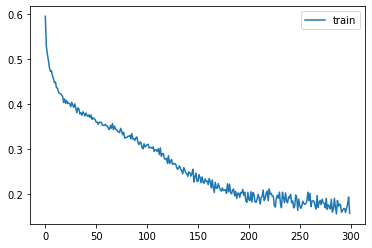

In [56]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.95164   0.94434   0.94798       521
           B    0.93996   0.94781   0.94387       479

    accuracy                        0.94600      1000
   macro avg    0.94580   0.94607   0.94592      1000
weighted avg    0.94605   0.94600   0.94601      1000

Confusion matrix, without normalization
[[492  29]
 [ 25 454]]


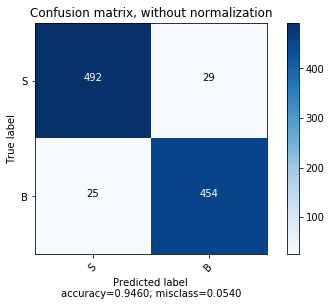

[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 

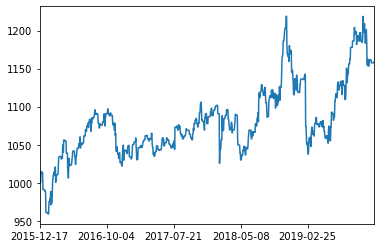

In [57]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 3s 728us/step - loss: 3.6103 - accuracy: 0.5230
Epoch 2/300
3996/3996 [==============================] - 1s 257us/step - loss: 0.7892 - accuracy: 0.54480s - loss: 0.8333 - accuracy - ETA: 0s - loss: 0.8090 - 
Epoch 3/300
3996/3996 [==============================] - 1s 315us/step - loss: 0.7308 - accuracy: 0.5485
Epoch 4/300
3996/3996 [==============================] - 1s 285us/step - loss: 0.7077 - accuracy: 0.5741
Epoch 5/300
3996/3996 [==============================] - 1s 247us/step - loss: 0.6938 - accuracy: 0.5813
Epoch 6/300
3996/3996 [==============================] - 1s 234us/step - loss: 0.6839 - accuracy: 0.5726
Epoch 7/300
 896/3996 [=====>........................] - ETA: 1s - loss: 0.6820 - accuracy: 0.5859

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 296us/step - loss: 0.6723 - accuracy: 0.5941
Epoch 8/300
3996/3996 [==============================] - 1s 250us/step - loss: 0.6610 - accuracy: 0.6089
Epoch 9/300
3996/3996 [==============================] - 1s 193us/step - loss: 0.6508 - accuracy: 0.6131
Epoch 10/300
3996/3996 [==============================] - 1s 191us/step - loss: 0.6582 - accuracy: 0.6061
Epoch 11/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.6447 - accuracy: 0.6299
Epoch 12/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.6354 - accuracy: 0.6369
Epoch 13/300
3996/3996 [==============================] - 1s 205us/step - loss: 0.6351 - accuracy: 0.6494
Epoch 14/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.6218 - accuracy: 0.6537
Epoch 15/300
3996/3996 [==============================] - 1s 188us/step - loss: 0.6192 - accuracy: 0.6522
Epoch 16/300
3996/3996 [==============================] - 1s 

Epoch 83/300
3996/3996 [==============================] - 1s 213us/step - loss: 0.5079 - accuracy: 0.7563
Epoch 84/300
3996/3996 [==============================] - 1s 172us/step - loss: 0.4855 - accuracy: 0.76480s - loss: 0.4827 - accuracy: 0.
Epoch 85/300
3996/3996 [==============================] - 1s 234us/step - loss: 0.4933 - accuracy: 0.7550
Epoch 86/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.4913 - accuracy: 0.76180s - loss: 0.4943 - accuracy
Epoch 87/300
3996/3996 [==============================] - 1s 233us/step - loss: 0.5064 - accuracy: 0.7482
Epoch 88/300
3996/3996 [==============================] - 1s 208us/step - loss: 0.5040 - accuracy: 0.74670s - loss: 0.5015 - accuracy - ETA: 0s - loss: 0.4991 - ac
Epoch 89/300
3996/3996 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.75 - 1s 241us/step - loss: 0.5031 - accuracy: 0.7538
Epoch 90/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.4900 - accuracy:

3996/3996 [==============================] - 1s 193us/step - loss: 0.4418 - accuracy: 0.7885
Epoch 156/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.4454 - accuracy: 0.7933
Epoch 157/300
3996/3996 [==============================] - 1s 209us/step - loss: 0.4590 - accuracy: 0.7855
Epoch 158/300
3996/3996 [==============================] - 1s 198us/step - loss: 0.4558 - accuracy: 0.7803
Epoch 159/300
3996/3996 [==============================] - 1s 214us/step - loss: 0.4445 - accuracy: 0.7920
Epoch 160/300
3996/3996 [==============================] - 1s 213us/step - loss: 0.4515 - accuracy: 0.7898
Epoch 161/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.4560 - accuracy: 0.7835
Epoch 162/300
3996/3996 [==============================] - 1s 198us/step - loss: 0.4467 - accuracy: 0.7913
Epoch 163/300
3996/3996 [==============================] - 1s 180us/step - loss: 0.4619 - accuracy: 0.7788
Epoch 164/300
3996/3996 [==========================

3996/3996 [==============================] - 1s 143us/step - loss: 0.4335 - accuracy: 0.7938
Epoch 231/300
3996/3996 [==============================] - 1s 149us/step - loss: 0.4260 - accuracy: 0.8008
Epoch 232/300
3996/3996 [==============================] - 1s 189us/step - loss: 0.4270 - accuracy: 0.8048
Epoch 233/300
3996/3996 [==============================] - 1s 137us/step - loss: 0.4151 - accuracy: 0.8076
Epoch 234/300
3996/3996 [==============================] - 1s 143us/step - loss: 0.4208 - accuracy: 0.8056
Epoch 235/300
3996/3996 [==============================] - 1s 231us/step - loss: 0.4201 - accuracy: 0.8028
Epoch 236/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.4263 - accuracy: 0.8098
Epoch 237/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.4232 - accuracy: 0.8076
Epoch 238/300
3996/3996 [==============================] - 1s 204us/step - loss: 0.4484 - accuracy: 0.7815
Epoch 239/300
3996/3996 [==========================

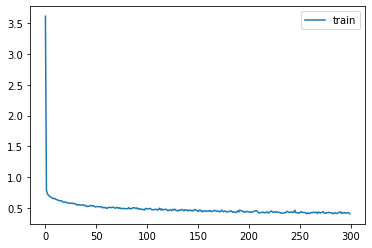

In [58]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

           S    0.79283   0.76392   0.77810       521
           B    0.75301   0.78288   0.76766       479

    accuracy                        0.77300      1000
   macro avg    0.77292   0.77340   0.77288      1000
weighted avg    0.77376   0.77300   0.77310      1000

Confusion matrix, without normalization
[[398 123]
 [104 375]]


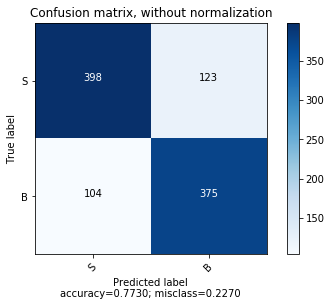

[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 

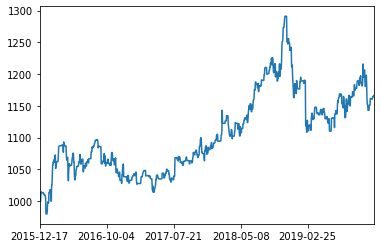

In [59]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 502us/step - loss: 0.6314 - accuracy: 0.6576
Epoch 2/300
3992/3992 [==============================] - 1s 192us/step - loss: 0.5722 - accuracy: 0.7209
Epoch 3/300
3992/3992 [==============================] - 1s 222us/step - loss: 0.5496 - accuracy: 0.7207
Epoch 4/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.5358 - accuracy: 0.7465
Epoch 5/300
3992/3992 [==============================] - 1s 291us/step - loss: 0.5256 - accuracy: 0.7482
Epoch 6/300
3992/3992 [==============================] - 1s 205us/step - loss: 0.5258 - accuracy: 0.7440
Epoch 7/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.5257 - accuracy: 0.74550s - loss: 0.5341 - accu
Epoch 8/300
3992/3992 [==============================] - 1s 198us/step - loss: 0.5183 - accuracy: 0.7515
Epoch 9/300
3992/3992 [==============================] - 1s 184us/step - loss: 0.5211 - accuracy: 0.74750s - loss: 0.5210 
Epoch 10/300


3992/3992 [==============================] - 1s 139us/step - loss: 0.4719 - accuracy: 0.7786
Epoch 76/300
3992/3992 [==============================] - 1s 165us/step - loss: 0.4685 - accuracy: 0.7813
Epoch 77/300
3992/3992 [==============================] - 0s 125us/step - loss: 0.4713 - accuracy: 0.7768
Epoch 78/300
3992/3992 [==============================] - 1s 150us/step - loss: 0.4707 - accuracy: 0.7771
Epoch 79/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.4705 - accuracy: 0.78210s - loss: 0.4798 - 
Epoch 80/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.4655 - accuracy: 0.7786
Epoch 81/300
3992/3992 [==============================] - 1s 175us/step - loss: 0.4682 - accuracy: 0.78260s - loss: 0.4763 - accuracy: 0.78 - ETA: 0s - loss: 0.4777 - accura
Epoch 82/300
3992/3992 [==============================] - 1s 205us/step - loss: 0.4704 - accuracy: 0.7791
Epoch 83/300
3992/3992 [==============================] - 1s 257us/step - los

3992/3992 [==============================] - 1s 135us/step - loss: 0.4504 - accuracy: 0.7876
Epoch 150/300
3992/3992 [==============================] - 1s 135us/step - loss: 0.4524 - accuracy: 0.7886
Epoch 151/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.4468 - accuracy: 0.7951
Epoch 152/300
3992/3992 [==============================] - 1s 141us/step - loss: 0.4501 - accuracy: 0.7938
Epoch 153/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.4531 - accuracy: 0.7891
Epoch 154/300
3992/3992 [==============================] - 1s 131us/step - loss: 0.4458 - accuracy: 0.7961
Epoch 155/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.4506 - accuracy: 0.7903
Epoch 156/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.4441 - accuracy: 0.7891
Epoch 157/300
3992/3992 [==============================] - 1s 144us/step - loss: 0.4438 - accuracy: 0.7866
Epoch 158/300
3992/3992 [==========================

Epoch 225/300
3992/3992 [==============================] - 0s 122us/step - loss: 0.4347 - accuracy: 0.7976
Epoch 226/300
3992/3992 [==============================] - 1s 127us/step - loss: 0.4309 - accuracy: 0.7998
Epoch 227/300
3992/3992 [==============================] - 0s 113us/step - loss: 0.4296 - accuracy: 0.7981
Epoch 228/300
3992/3992 [==============================] - 0s 120us/step - loss: 0.4264 - accuracy: 0.7983
Epoch 229/300
3992/3992 [==============================] - 0s 122us/step - loss: 0.4328 - accuracy: 0.8006
Epoch 230/300
3992/3992 [==============================] - 1s 135us/step - loss: 0.4307 - accuracy: 0.79860s - loss: 0.4275 - accuracy: 0.
Epoch 231/300
3992/3992 [==============================] - 0s 117us/step - loss: 0.4283 - accuracy: 0.7963
Epoch 232/300
3992/3992 [==============================] - 0s 114us/step - loss: 0.4246 - accuracy: 0.8049
Epoch 233/300
3992/3992 [==============================] - 0s 110us/step - loss: 0.4283 - accuracy: 0.7971
Epoch

3992/3992 [==============================] - 1s 209us/step - loss: 0.4171 - accuracy: 0.8026


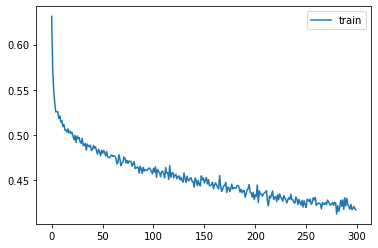

In [60]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.80222   0.82042   0.81121       529
           B    0.79258   0.77234   0.78233       470

    accuracy                        0.79780       999
   macro avg    0.79740   0.79638   0.79677       999
weighted avg    0.79768   0.79780   0.79762       999

Confusion matrix, without normalization
[[434  95]
 [107 363]]


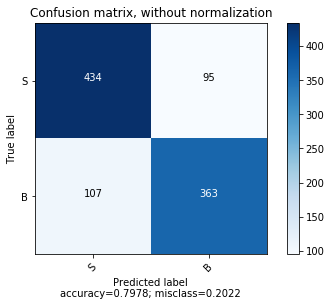

[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 

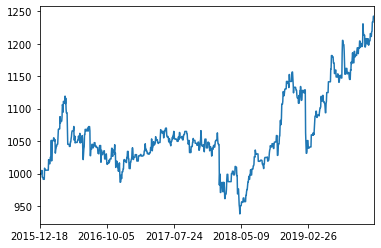

In [61]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 441us/step - loss: 0.6197 - accuracy: 0.6688
Epoch 2/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.5487 - accuracy: 0.7244
Epoch 3/300
3992/3992 [==============================] - 0s 117us/step - loss: 0.5308 - accuracy: 0.7412
Epoch 4/300
3992/3992 [==============================] - 0s 113us/step - loss: 0.5250 - accuracy: 0.7513
Epoch 5/300
3992/3992 [==============================] - 0s 122us/step - loss: 0.5083 - accuracy: 0.7573
Epoch 6/300
3992/3992 [==============================] - 1s 143us/step - loss: 0.5066 - accuracy: 0.7638
Epoch 7/300
3992/3992 [==============================] - 1s 157us/step - loss: 0.4980 - accuracy: 0.7628
Epoch 8/300
3992/3992 [==============================] - 1s 169us/step - loss: 0.4949 - accuracy: 0.7630
Epoch 9/300
3992/3992 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.77 - 1s 183us/step - loss: 0.4868 - accuracy: 0.7791
Epoch 10/300


3992/3992 [==============================] - 0s 122us/step - loss: 0.2580 - accuracy: 0.8900
Epoch 78/300
3992/3992 [==============================] - 1s 134us/step - loss: 0.2618 - accuracy: 0.8875
Epoch 79/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.2803 - accuracy: 0.8785
Epoch 80/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.2745 - accuracy: 0.8768
Epoch 81/300
3992/3992 [==============================] - 1s 136us/step - loss: 0.3143 - accuracy: 0.8620
Epoch 82/300
3992/3992 [==============================] - 1s 136us/step - loss: 0.2723 - accuracy: 0.8780
Epoch 83/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.2659 - accuracy: 0.8800
Epoch 84/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.2722 - accuracy: 0.8830
Epoch 85/300
3992/3992 [==============================] - 1s 137us/step - loss: 0.2608 - accuracy: 0.8828
Epoch 86/300
3992/3992 [==============================] - 1

Epoch 153/300
3992/3992 [==============================] - 1s 216us/step - loss: 0.2745 - accuracy: 0.8780
Epoch 154/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.2615 - accuracy: 0.8880
Epoch 155/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.2495 - accuracy: 0.8920
Epoch 156/300
3992/3992 [==============================] - 1s 169us/step - loss: 0.2560 - accuracy: 0.8910
Epoch 157/300
3992/3992 [==============================] - 1s 251us/step - loss: 0.2668 - accuracy: 0.8828
Epoch 158/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.2696 - accuracy: 0.8803
Epoch 159/300
3992/3992 [==============================] - 1s 190us/step - loss: 0.2806 - accuracy: 0.88050s - loss: 0.303
Epoch 160/300
3992/3992 [==============================] - 1s 161us/step - loss: 0.2552 - accuracy: 0.8903
Epoch 161/300
3992/3992 [==============================] - 1s 155us/step - loss: 0.2308 - accuracy: 0.9021
Epoch 162/300
3992/39

Epoch 228/300
3992/3992 [==============================] - 1s 138us/step - loss: 0.2555 - accuracy: 0.8918
Epoch 229/300
3992/3992 [==============================] - 1s 154us/step - loss: 0.2577 - accuracy: 0.8890
Epoch 230/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.2593 - accuracy: 0.8888
Epoch 231/300
3992/3992 [==============================] - 1s 154us/step - loss: 0.2384 - accuracy: 0.9023
Epoch 232/300
3992/3992 [==============================] - 1s 143us/step - loss: 0.2284 - accuracy: 0.9013
Epoch 233/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.2609 - accuracy: 0.8878
Epoch 234/300
3992/3992 [==============================] - 1s 160us/step - loss: 0.2696 - accuracy: 0.8760
Epoch 235/300
3992/3992 [==============================] - 2s 429us/step - loss: 0.2249 - accuracy: 0.9053
Epoch 236/300
3992/3992 [==============================] - 2s 452us/step - loss: 0.2462 - accuracy: 0.89500s - loss: 0.2430 - accuracy: 
Epoch 2

3992/3992 [==============================] - 1s 246us/step - loss: 0.2133 - accuracy: 0.9051


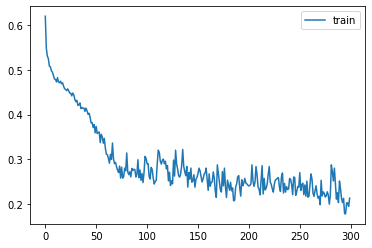

In [62]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.94707   0.94707   0.94707       529
           B    0.94043   0.94043   0.94043       470

    accuracy                        0.94394       999
   macro avg    0.94375   0.94375   0.94375       999
weighted avg    0.94394   0.94394   0.94394       999

Confusion matrix, without normalization
[[501  28]
 [ 28 442]]


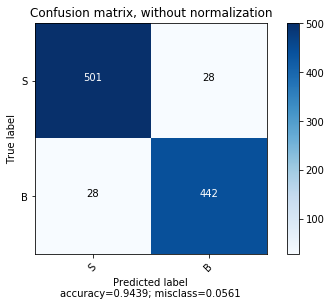

[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 

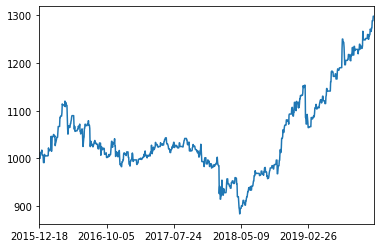

In [63]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 581us/step - loss: 0.6256 - accuracy: 0.6896
Epoch 2/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.5450 - accuracy: 0.7277
Epoch 3/300
3992/3992 [==============================] - 1s 174us/step - loss: 0.5311 - accuracy: 0.7452
Epoch 4/300
3992/3992 [==============================] - 1s 199us/step - loss: 0.5099 - accuracy: 0.7543
Epoch 5/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.5039 - accuracy: 0.7618
Epoch 6/300
3992/3992 [==============================] - 1s 173us/step - loss: 0.4961 - accuracy: 0.7638
Epoch 7/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.4820 - accuracy: 0.7670
Epoch 8/300
3992/3992 [==============================] - 1s 194us/step - loss: 0.4765 - accuracy: 0.7715
Epoch 9/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.4714 - accuracy: 0.7808
Epoch 10/300
3992/3992 [==============================]

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 2s 396us/step - loss: 0.3351 - accuracy: 0.85070s - loss: 0.3269 - accu
Epoch 60/300
3992/3992 [==============================] - 1s 221us/step - loss: 0.3235 - accuracy: 0.8547
Epoch 61/300
3992/3992 [==============================] - 1s 191us/step - loss: 0.3310 - accuracy: 0.8545
Epoch 62/300
3992/3992 [==============================] - 1s 373us/step - loss: 0.3265 - accuracy: 0.8525
Epoch 63/300
 320/3992 [=>............................] - ETA: 2s - loss: 0.3220 - accuracy: 0.8750 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 2s 454us/step - loss: 0.3230 - accuracy: 0.8585
Epoch 64/300
3992/3992 [==============================] - 1s 358us/step - loss: 0.3256 - accuracy: 0.8605
Epoch 65/300
3992/3992 [==============================] - 2s 379us/step - loss: 0.3258 - accuracy: 0.8597
Epoch 66/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.3340 - accuracy: 0.8522
Epoch 67/300
3992/3992 [==============================] - 1s 300us/step - loss: 0.3131 - accuracy: 0.8620
Epoch 68/300
3992/3992 [==============================] - 1s 276us/step - loss: 0.3140 - accuracy: 0.8600
Epoch 69/300
3992/3992 [==============================] - 1s 245us/step - loss: 0.3179 - accuracy: 0.8585
Epoch 70/300
3992/3992 [==============================] - 1s 266us/step - loss: 0.3121 - accuracy: 0.8617
Epoch 71/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.3200 - accuracy: 0.8550
Epoch 72/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 1s 183us/step - loss: 0.2402 - accuracy: 0.9001
Epoch 139/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.2540 - accuracy: 0.89180s - loss: 0.2500 - accuracy: 
Epoch 140/300
3992/3992 [==============================] - 1s 245us/step - loss: 0.2581 - accuracy: 0.8910
Epoch 141/300
3992/3992 [==============================] - 1s 185us/step - loss: 0.2599 - accuracy: 0.8920
Epoch 142/300
3992/3992 [==============================] - 1s 167us/step - loss: 0.2537 - accuracy: 0.8970
Epoch 143/300
3992/3992 [==============================] - 1s 173us/step - loss: 0.2530 - accuracy: 0.8935
Epoch 144/300
3992/3992 [==============================] - 1s 174us/step - loss: 0.2588 - accuracy: 0.8913
Epoch 145/300
3992/3992 [==============================] - 1s 221us/step - loss: 0.2430 - accuracy: 0.89600s - loss: 0.2583 
Epoch 146/300
3992/3992 [==============================] - 1s 166us/step - loss: 0.2506 - accuracy: 0.8978
Epo

3992/3992 [==============================] - 1s 134us/step - loss: 0.2078 - accuracy: 0.9136
Epoch 214/300
3992/3992 [==============================] - 1s 138us/step - loss: 0.2172 - accuracy: 0.9061
Epoch 215/300
3992/3992 [==============================] - 1s 133us/step - loss: 0.2155 - accuracy: 0.9123
Epoch 216/300
3992/3992 [==============================] - 0s 120us/step - loss: 0.2126 - accuracy: 0.9103
Epoch 217/300
3992/3992 [==============================] - 0s 121us/step - loss: 0.2213 - accuracy: 0.9121
Epoch 218/300
3992/3992 [==============================] - 0s 123us/step - loss: 0.2031 - accuracy: 0.9148
Epoch 219/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.2118 - accuracy: 0.9123
Epoch 220/300
3992/3992 [==============================] - 1s 144us/step - loss: 0.2147 - accuracy: 0.9091
Epoch 221/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.2220 - accuracy: 0.9103
Epoch 222/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 154us/step - loss: 0.1642 - accuracy: 0.9334
Epoch 289/300
3992/3992 [==============================] - 1s 142us/step - loss: 0.1718 - accuracy: 0.9304
Epoch 290/300
3992/3992 [==============================] - 1s 137us/step - loss: 0.1739 - accuracy: 0.9296
Epoch 291/300
3992/3992 [==============================] - 1s 235us/step - loss: 0.1732 - accuracy: 0.9254
Epoch 292/300
3992/3992 [==============================] - 1s 224us/step - loss: 0.1810 - accuracy: 0.92110s - loss: 0.173
Epoch 293/300
3992/3992 [==============================] - 1s 144us/step - loss: 0.1849 - accuracy: 0.92130s - loss: 0.1727 - 
Epoch 294/300
3992/3992 [==============================] - 1s 141us/step - loss: 0.1876 - accuracy: 0.9256
Epoch 295/300
3992/3992 [==============================] - 1s 143us/step - loss: 0.1810 - accuracy: 0.9269
Epoch 296/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.1937 - accuracy: 0.9198
Epoch 297/300
3

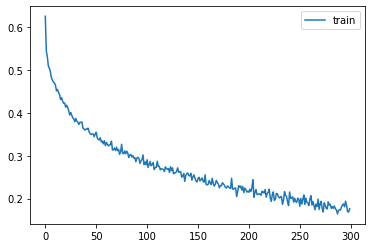

In [64]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.87928   0.82609   0.85185       529
           B    0.81673   0.87234   0.84362       470

    accuracy                        0.84785       999
   macro avg    0.84800   0.84921   0.84774       999
weighted avg    0.84985   0.84785   0.84798       999

Confusion matrix, without normalization
[[437  92]
 [ 60 410]]


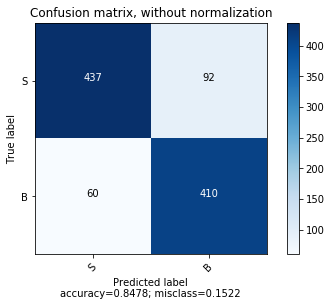

[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 

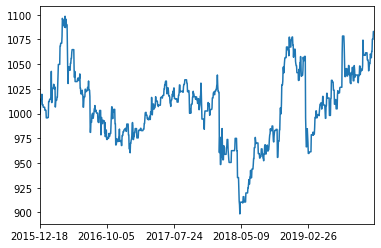

In [65]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 344us/step - loss: 3.9484 - accuracy: 0.5183
Epoch 2/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.7189 - accuracy: 0.5403
Epoch 3/300
3992/3992 [==============================] - 1s 155us/step - loss: 0.6968 - accuracy: 0.5644
Epoch 4/300
3992/3992 [==============================] - 1s 184us/step - loss: 0.6804 - accuracy: 0.5804
Epoch 5/300
3992/3992 [==============================] - 1s 288us/step - loss: 0.6640 - accuracy: 0.5922
Epoch 6/300
3992/3992 [==============================] - 1s 211us/step - loss: 0.6522 - accuracy: 0.6035
Epoch 7/300
3992/3992 [==============================] - 1s 239us/step - loss: 0.6527 - accuracy: 0.6002
Epoch 8/300
3992/3992 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.59 - 1s 305us/step - loss: 0.6521 - accuracy: 0.5977
Epoch 9/300
3992/3992 [==============================] - 1s 247us/step - loss: 0.6433 - accuracy: 0.6137
Epoch 10/300


3992/3992 [==============================] - 1s 239us/step - loss: 0.5221 - accuracy: 0.7202
Epoch 77/300
3992/3992 [==============================] - 1s 231us/step - loss: 0.5193 - accuracy: 0.7360
Epoch 78/300
3992/3992 [==============================] - 1s 196us/step - loss: 0.5153 - accuracy: 0.7347
Epoch 79/300
3992/3992 [==============================] - 1s 187us/step - loss: 0.5156 - accuracy: 0.7247
Epoch 80/300
3992/3992 [==============================] - 1s 295us/step - loss: 0.5144 - accuracy: 0.7252
Epoch 81/300
3992/3992 [==============================] - 1s 178us/step - loss: 0.5274 - accuracy: 0.7164
Epoch 82/300
3992/3992 [==============================] - 1s 206us/step - loss: 0.5056 - accuracy: 0.7417
Epoch 83/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.5013 - accuracy: 0.7317
Epoch 84/300
3992/3992 [==============================] - 1s 202us/step - loss: 0.5007 - accuracy: 0.7385
Epoch 85/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 1s 261us/step - loss: 0.4427 - accuracy: 0.7796
Epoch 153/300
3992/3992 [==============================] - 1s 258us/step - loss: 0.4584 - accuracy: 0.7680
Epoch 154/300
3992/3992 [==============================] - 1s 276us/step - loss: 0.4570 - accuracy: 0.7713
Epoch 155/300
3992/3992 [==============================] - 2s 598us/step - loss: 0.4611 - accuracy: 0.7583
Epoch 156/300
3992/3992 [==============================] - 2s 562us/step - loss: 0.4627 - accuracy: 0.7725
Epoch 157/300
3992/3992 [==============================] - 2s 540us/step - loss: 0.4577 - accuracy: 0.7563
Epoch 158/300
3992/3992 [==============================] - 1s 277us/step - loss: 0.4438 - accuracy: 0.7753
Epoch 159/300
3992/3992 [==============================] - 1s 263us/step - loss: 0.4603 - accuracy: 0.7633
Epoch 160/300
3992/3992 [==============================] - 1s 242us/step - loss: 0.4531 - accuracy: 0.7685
Epoch 161/300
3992/3992 [==========================

3992/3992 [==============================] - 2s 489us/step - loss: 0.4309 - accuracy: 0.77860s - loss: 0.4345 - accuracy: 0.77 - ETA: 0s - loss: 0.4313 - accuracy: 0.77
Epoch 228/300
3992/3992 [==============================] - 2s 426us/step - loss: 0.4251 - accuracy: 0.7928
Epoch 229/300
3992/3992 [==============================] - 2s 389us/step - loss: 0.4307 - accuracy: 0.7853
Epoch 230/300
3992/3992 [==============================] - 1s 250us/step - loss: 0.4363 - accuracy: 0.7715
Epoch 231/300
3992/3992 [==============================] - 1s 295us/step - loss: 0.4202 - accuracy: 0.7971
Epoch 232/300
3992/3992 [==============================] - 1s 271us/step - loss: 0.4216 - accuracy: 0.7806
Epoch 233/300
3992/3992 [==============================] - 1s 281us/step - loss: 0.4259 - accuracy: 0.7903
Epoch 234/300
3992/3992 [==============================] - 1s 295us/step - loss: 0.4300 - accuracy: 0.7768
Epoch 235/300
3992/3992 [==============================] - 1s 266us/step - loss: 0

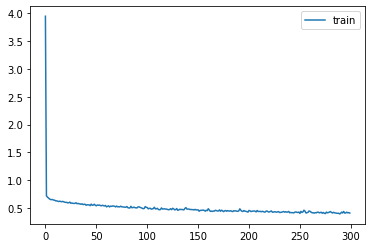

In [66]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

           S    0.81798   0.70510   0.75736       529
           B    0.71271   0.82340   0.76407       470

    accuracy                        0.76076       999
   macro avg    0.76534   0.76425   0.76071       999
weighted avg    0.76845   0.76076   0.76052       999

Confusion matrix, without normalization
[[373 156]
 [ 83 387]]


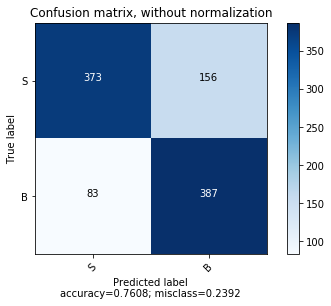

[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 

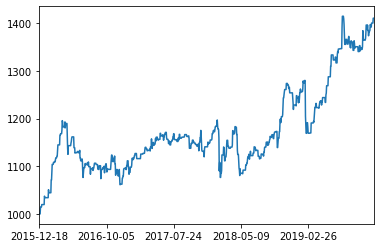

In [67]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 572us/step - loss: 2.0384 - accuracy: 0.2001
Epoch 2/300
3999/3999 [==============================] - 1s 201us/step - loss: 1.9362 - accuracy: 0.2251
Epoch 3/300
3999/3999 [==============================] - 1s 237us/step - loss: 1.9258 - accuracy: 0.22630s - loss: 1.9313 - accura - ETA: 0s - loss: 1.9220 - accu
Epoch 4/300
3999/3999 [==============================] - 1s 193us/step - loss: 1.9192 - accuracy: 0.2318
Epoch 5/300
3999/3999 [==============================] - 1s 200us/step - loss: 1.9108 - accuracy: 0.2251
Epoch 6/300
3999/3999 [==============================] - 1s 224us/step - loss: 1.9065 - accuracy: 0.2273
Epoch 7/300
3999/3999 [==============================] - 1s 230us/step - loss: 1.9028 - accuracy: 0.2356
Epoch 8/300
3999/3999 [==============================] - 1s 157us/step - loss: 1.9038 - accuracy: 0.22980s - loss: 1.9065 - accuracy
Epoch 9/300
3999/3999 [==============================] - 1s 204us/step - l

3999/3999 [==============================] - 0s 120us/step - loss: 1.7408 - accuracy: 0.2793
Epoch 74/300
3999/3999 [==============================] - 0s 110us/step - loss: 1.7329 - accuracy: 0.2781
Epoch 75/300
3999/3999 [==============================] - 0s 116us/step - loss: 1.7322 - accuracy: 0.2841
Epoch 76/300
3999/3999 [==============================] - 0s 118us/step - loss: 1.7314 - accuracy: 0.2806
Epoch 77/300
3999/3999 [==============================] - 1s 139us/step - loss: 1.7299 - accuracy: 0.2886
Epoch 78/300
3999/3999 [==============================] - 0s 112us/step - loss: 1.7238 - accuracy: 0.2816
Epoch 79/300
3999/3999 [==============================] - 1s 139us/step - loss: 1.7195 - accuracy: 0.2871
Epoch 80/300
3999/3999 [==============================] - 1s 130us/step - loss: 1.7333 - accuracy: 0.2773
Epoch 81/300
3999/3999 [==============================] - 1s 152us/step - loss: 1.7171 - accuracy: 0.2858
Epoch 82/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 269us/step - loss: 1.6902 - accuracy: 0.3038
Epoch 149/300
3999/3999 [==============================] - 1s 147us/step - loss: 1.6826 - accuracy: 0.3008
Epoch 150/300
3999/3999 [==============================] - 1s 187us/step - loss: 1.6798 - accuracy: 0.30310s - loss: 1.6876 - 
Epoch 151/300
3999/3999 [==============================] - 1s 146us/step - loss: 1.7025 - accuracy: 0.2941
Epoch 152/300
3999/3999 [==============================] - 1s 133us/step - loss: 1.6978 - accuracy: 0.2958
Epoch 153/300
3999/3999 [==============================] - 1s 156us/step - loss: 1.6990 - accuracy: 0.2868
Epoch 154/300
3999/3999 [==============================] - 1s 167us/step - loss: 1.6922 - accuracy: 0.3011
Epoch 155/300
3999/3999 [==============================] - 1s 186us/step - loss: 1.6923 - accuracy: 0.31080s - loss:
Epoch 156/300
3999/3999 [==============================] - 1s 140us/step - loss: 1.6847 - accuracy: 0.3001
Epoch 157/300
3999/39

Epoch 222/300
3999/3999 [==============================] - 1s 294us/step - loss: 1.6883 - accuracy: 0.3056
Epoch 223/300
3999/3999 [==============================] - 1s 203us/step - loss: 1.6784 - accuracy: 0.3123
Epoch 224/300
3999/3999 [==============================] - 1s 154us/step - loss: 1.6735 - accuracy: 0.30960s - loss: 1.6540 
Epoch 225/300
3999/3999 [==============================] - 1s 125us/step - loss: 1.6782 - accuracy: 0.2958
Epoch 226/300
3999/3999 [==============================] - 1s 241us/step - loss: 1.6779 - accuracy: 0.3056
Epoch 227/300
3999/3999 [==============================] - 1s 350us/step - loss: 1.6880 - accuracy: 0.3091
Epoch 228/300
3999/3999 [==============================] - 1s 175us/step - loss: 1.6750 - accuracy: 0.3081
Epoch 229/300
3999/3999 [==============================] - 2s 377us/step - loss: 1.6785 - accuracy: 0.3128
Epoch 230/300
3999/3999 [==============================] - 1s 340us/step - loss: 1.6853 - accuracy: 0.3096
Epoch 231/300
3999/

Epoch 298/300
3999/3999 [==============================] - 0s 124us/step - loss: 1.6817 - accuracy: 0.3116
Epoch 299/300
3999/3999 [==============================] - 1s 155us/step - loss: 1.6727 - accuracy: 0.3146
Epoch 300/300
3999/3999 [==============================] - 0s 121us/step - loss: 1.6822 - accuracy: 0.3126


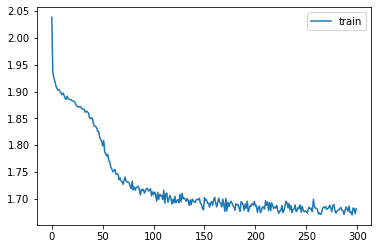

In [68]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.87500   0.14286   0.24561        49
          B2    0.00000   0.00000   0.00000        99
          B1    0.00000   0.00000   0.00000       135
          B0    0.00000   0.00000   0.00000       201
          S0    0.00000   0.00000   0.00000       207
          S1    0.00000   0.00000   0.00000       149
          S2    0.00000   0.00000   0.00000       114
          S3    0.00000   0.00000   0.00000        46

   micro avg    0.87500   0.00700   0.01389      1000
   macro avg    0.10938   0.01786   0.03070      1000
weighted avg    0.04288   0.00700   0.01204      1000
 samples avg    0.00700   0.00700   0.00700      1000

Confusion matrix, without normalization
[[ 49   0   0   0   0   0   0   0]
 [ 99   0   0   0   0   0   0   0]
 [135   0   0   0   0   0   0   0]
 [201   0   0   0   0   0   0   0]
 [207   0   0   0   0   0   0   0]
 [149   0

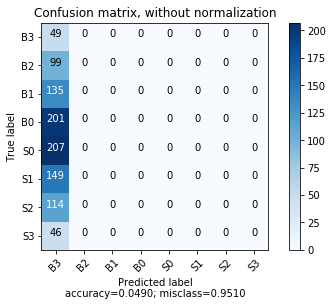

[4, 4, 3, 5, 3, 4, 6, 3, 6, 1, 4, 3, 6, 2, 6, 1, 3, 6, 3, 6, 6, 4, 3, 4, 3, 1, 6, 1, 6, 4, 1, 2, 3, 3, 4, 1, 3, 6, 6, 4, 3, 6, 3, 6, 3, 4, 3, 6, 4, 6, 6, 3, 3, 1, 4, 3, 4, 4, 6, 2, 3, 4, 5, 4, 6, 3, 6, 4, 5, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 5, 5, 6, 4, 6, 3, 6, 4, 3, 3, 4, 3, 4, 6, 1, 4, 2, 6, 3, 4, 3, 1, 4, 2, 3, 4, 3, 3, 3, 3, 6, 3, 4, 6, 2, 3, 4, 3, 3, 4, 5, 4, 3, 4, 4, 4, 6, 3, 4, 3, 2, 1, 1, 4, 3, 3, 3, 6, 4, 4, 3, 3, 4, 3, 4, 1, 4, 3, 3, 4, 5, 3, 5, 3, 4, 4, 3, 4, 2, 3, 3, 6, 5, 4, 0, 3, 4, 5, 2, 6, 6, 2, 1, 3, 3, 5, 4, 6, 1, 4, 4, 0, 4, 2, 6, 4, 4, 1, 2, 5, 2, 1, 3, 4, 3, 3, 4, 2, 6, 3, 4, 3, 5, 4, 6, 4, 4, 4, 6, 3, 5, 4, 4, 6, 3, 2, 2, 6, 4, 4, 4, 4, 2, 6, 1, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 6, 5, 1, 1, 5, 2, 3, 4, 3, 1, 6, 1, 3, 4, 4, 4, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 1, 6, 5, 3, 4, 4, 5, 4, 4, 3, 3, 4, 1, 6, 4, 3, 4, 4, 3, 6, 3, 6, 0, 3, 3, 1, 5, 1, 6, 5, 3, 3, 4, 5, 6, 4, 4, 1, 6, 6, 3, 4, 3, 3, 3, 4, 5, 0, 3, 1, 3, 4, 4, 4, 4, 4, 3, 4, 6, 3, 2, 4, 4, 

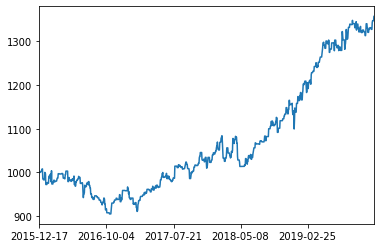

In [78]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 3s 721us/step - loss: 1.9723 - accuracy: 0.2076: 13s - loss: 2.1468 -
Epoch 2/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.9151 - accuracy: 0.2206
Epoch 3/300
3999/3999 [==============================] - 0s 76us/step - loss: 1.8958 - accuracy: 0.2353
Epoch 4/300
3999/3999 [==============================] - 1s 205us/step - loss: 1.8798 - accuracy: 0.22660s - loss: 1.8818 - accuracy
Epoch 5/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.8735 - accuracy: 0.2323
Epoch 6/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.8576 - accuracy: 0.2391
Epoch 7/300
3999/3999 [==============================] - 1s 314us/step - loss: 1.8597 - accuracy: 0.2341
Epoch 8/300
3999/3999 [==============================] - 1s 158us/step - loss: 1.8480 - accuracy: 0.2356
Epoch 9/300
3999/3999 [==============================] - 1s 203us/step - loss: 1.8340 - accuracy: 0.2453
Epoch 10

3999/3999 [==============================] - 1s 259us/step - loss: 1.0817 - accuracy: 0.5529
Epoch 78/300
3999/3999 [==============================] - 1s 275us/step - loss: 1.0812 - accuracy: 0.5494
Epoch 79/300
3999/3999 [==============================] - 0s 79us/step - loss: 1.0591 - accuracy: 0.5574
Epoch 80/300
3999/3999 [==============================] - 0s 70us/step - loss: 1.0669 - accuracy: 0.5546
Epoch 81/300
3999/3999 [==============================] - 0s 69us/step - loss: 1.0554 - accuracy: 0.5654
Epoch 82/300
3999/3999 [==============================] - 0s 63us/step - loss: 1.0405 - accuracy: 0.5641
Epoch 83/300
3999/3999 [==============================] - 0s 69us/step - loss: 1.0551 - accuracy: 0.5631
Epoch 84/300
3999/3999 [==============================] - 1s 203us/step - loss: 1.0628 - accuracy: 0.5536
Epoch 85/300
3999/3999 [==============================] - 1s 136us/step - loss: 1.0516 - accuracy: 0.5704
Epoch 86/300
3999/3999 [==============================] - 1s 286

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 328us/step - loss: 0.9850 - accuracy: 0.5999
Epoch 125/300
3999/3999 [==============================] - 1s 308us/step - loss: 0.9817 - accuracy: 0.5844
Epoch 126/300
3999/3999 [==============================] - 1s 261us/step - loss: 0.9662 - accuracy: 0.6004
Epoch 127/300
3999/3999 [==============================] - 1s 286us/step - loss: 0.9877 - accuracy: 0.5849
Epoch 128/300
3999/3999 [==============================] - 1s 339us/step - loss: 0.9708 - accuracy: 0.5869
Epoch 129/300
3999/3999 [==============================] - 1s 306us/step - loss: 0.9807 - accuracy: 0.59390s - loss: 0.9809 - accura
Epoch 130/300
3999/3999 [==============================] - 1s 254us/step - loss: 0.9783 - accuracy: 0.5901
Epoch 131/300
3999/3999 [==============================] - 1s 316us/step - loss: 0.9808 - accuracy: 0.5824
Epoch 132/300
1312/3999 [========>.....................] - ETA: 0s - loss: 0.9360 - accuracy: 0.6067

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 356us/step - loss: 0.9511 - accuracy: 0.5924
Epoch 133/300
3999/3999 [==============================] - 1s 286us/step - loss: 0.9567 - accuracy: 0.6044
Epoch 134/300
3999/3999 [==============================] - 1s 331us/step - loss: 0.9641 - accuracy: 0.5974
Epoch 135/300
3999/3999 [==============================] - 1s 326us/step - loss: 0.9834 - accuracy: 0.5916
Epoch 136/300
3999/3999 [==============================] - 2s 495us/step - loss: 0.9724 - accuracy: 0.5959
Epoch 137/300
3999/3999 [==============================] - 2s 420us/step - loss: 0.9711 - accuracy: 0.5859
Epoch 138/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.9714 - accuracy: 0.59540s - loss: 1.1132 
Epoch 139/300
3999/3999 [==============================] - 2s 482us/step - loss: 0.9700 - accuracy: 0.5989
Epoch 140/300
3999/3999 [==============================] - 1s 268us/step - loss: 0.9647 - accuracy: 0.5971
Epoch 141/300
3999/3999 [========

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 378us/step - loss: 0.9327 - accuracy: 0.6104
Epoch 177/300
3999/3999 [==============================] - 1s 288us/step - loss: 0.9427 - accuracy: 0.6089
Epoch 178/300
3999/3999 [==============================] - 1s 294us/step - loss: 0.9303 - accuracy: 0.6109
Epoch 179/300
 896/3999 [=====>........................] - ETA: 0s - loss: 0.9138 - accuracy: 0.6261

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 328us/step - loss: 0.9254 - accuracy: 0.6142
Epoch 180/300
3999/3999 [==============================] - 1s 311us/step - loss: 0.9427 - accuracy: 0.60490s - loss: 0.9495 - accuracy: 
Epoch 181/300
3999/3999 [==============================] - 1s 283us/step - loss: 0.9403 - accuracy: 0.6092
Epoch 182/300
3999/3999 [==============================] - 1s 254us/step - loss: 0.9385 - accuracy: 0.60620s - loss: 0.9441 - accuracy: 
Epoch 183/300
3999/3999 [==============================] - 1s 273us/step - loss: 0.9293 - accuracy: 0.6034
Epoch 184/300
3999/3999 [==============================] - 1s 323us/step - loss: 0.9156 - accuracy: 0.6144
Epoch 185/300
3999/3999 [==============================] - 1s 262us/step - loss: 0.9392 - accuracy: 0.6019
Epoch 186/300
3999/3999 [==============================] - 1s 284us/step - loss: 0.9258 - accuracy: 0.6207
Epoch 187/300
1120/3999 [=======>......................] - ETA: 0s - loss: 0.8918 - accuracy: 0.63

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 388us/step - loss: 0.9254 - accuracy: 0.6084
Epoch 188/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.9099 - accuracy: 0.6232
Epoch 189/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.9434 - accuracy: 0.6174
Epoch 190/300
3999/3999 [==============================] - 1s 361us/step - loss: 0.9279 - accuracy: 0.6082
Epoch 191/300
3999/3999 [==============================] - 1s 336us/step - loss: 0.9080 - accuracy: 0.6209
Epoch 192/300
3999/3999 [==============================] - 1s 341us/step - loss: 0.9104 - accuracy: 0.6177
Epoch 193/300
3999/3999 [==============================] - 1s 267us/step - loss: 0.9308 - accuracy: 0.6069
Epoch 194/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.9222 - accuracy: 0.6209
Epoch 195/300
3999/3999 [==============================] - 1s 270us/step - loss: 0.9230 - accuracy: 0.6162
Epoch 196/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 291us/step - loss: 0.9236 - accuracy: 0.6184
Epoch 205/300
3999/3999 [==============================] - 1s 279us/step - loss: 0.9081 - accuracy: 0.62490s - loss:
Epoch 206/300
3999/3999 [==============================] - 1s 270us/step - loss: 0.9114 - accuracy: 0.6239
Epoch 207/300
3999/3999 [==============================] - 1s 241us/step - loss: 0.9396 - accuracy: 0.6044
Epoch 208/300
3999/3999 [==============================] - 1s 278us/step - loss: 0.9235 - accuracy: 0.6122
Epoch 209/300
3999/3999 [==============================] - 1s 293us/step - loss: 0.9218 - accuracy: 0.6242
Epoch 210/300
3999/3999 [==============================] - 1s 284us/step - loss: 0.9138 - accuracy: 0.6117
Epoch 211/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.9058 - accuracy: 0.6284
Epoch 212/300
3999/3999 [==============================] - 1s 297us/step - loss: 0.9080 - accuracy: 0.6237
Epoch 213/300
3999/3999 [================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 311us/step - loss: 0.9266 - accuracy: 0.6232
Epoch 242/300
3999/3999 [==============================] - 1s 261us/step - loss: 0.8971 - accuracy: 0.6309
Epoch 243/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.8876 - accuracy: 0.6297
Epoch 244/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.9071 - accuracy: 0.6152
Epoch 245/300
 832/3999 [=====>........................] - ETA: 0s - loss: 0.8084 - accuracy: 0.6647

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 292us/step - loss: 0.9014 - accuracy: 0.6249
Epoch 246/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.9098 - accuracy: 0.6199
Epoch 247/300
3999/3999 [==============================] - 1s 257us/step - loss: 0.8801 - accuracy: 0.6342
Epoch 248/300
1344/3999 [=========>....................] - ETA: 0s - loss: 0.9477 - accuracy: 0.6079

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 270us/step - loss: 0.9130 - accuracy: 0.6227
Epoch 249/300
3999/3999 [==============================] - 1s 283us/step - loss: 0.8947 - accuracy: 0.6374
Epoch 250/300
3999/3999 [==============================] - 1s 255us/step - loss: 0.8996 - accuracy: 0.6327
Epoch 251/300
3999/3999 [==============================] - 1s 205us/step - loss: 0.8852 - accuracy: 0.6397
Epoch 252/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.9008 - accuracy: 0.6334
Epoch 253/300
 352/3999 [=>............................] - ETA: 2s - loss: 0.8659 - accuracy: 0.6307 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 287us/step - loss: 0.8838 - accuracy: 0.6297
Epoch 254/300
3999/3999 [==============================] - 1s 263us/step - loss: 0.8909 - accuracy: 0.6357
Epoch 255/300
3999/3999 [==============================] - 1s 255us/step - loss: 0.8978 - accuracy: 0.6232
Epoch 256/300
3999/3999 [==============================] - 1s 252us/step - loss: 0.9036 - accuracy: 0.6324
Epoch 257/300
1120/3999 [=======>......................] - ETA: 0s - loss: 0.9059 - accuracy: 0.6187

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 318us/step - loss: 0.9255 - accuracy: 0.6104
Epoch 258/300
3999/3999 [==============================] - 1s 273us/step - loss: 0.9110 - accuracy: 0.6244
Epoch 259/300
3999/3999 [==============================] - 1s 288us/step - loss: 0.8998 - accuracy: 0.6234
Epoch 260/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.8951 - accuracy: 0.6332
Epoch 261/300
3999/3999 [==============================] - 1s 330us/step - loss: 0.8675 - accuracy: 0.6429
Epoch 262/300
3999/3999 [==============================] - 1s 310us/step - loss: 0.9071 - accuracy: 0.6279
Epoch 263/300
3999/3999 [==============================] - 1s 302us/step - loss: 0.8766 - accuracy: 0.6379
Epoch 264/300
3999/3999 [==============================] - 1s 257us/step - loss: 0.8698 - accuracy: 0.6417
Epoch 265/300
3999/3999 [==============================] - 1s 340us/step - loss: 0.8890 - accuracy: 0.6369
Epoch 266/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 302us/step - loss: 0.8809 - accuracy: 0.6387
Epoch 290/300
3999/3999 [==============================] - 1s 215us/step - loss: 0.8783 - accuracy: 0.64340s - loss: 0.8606 - accuracy: 
Epoch 291/300
3999/3999 [==============================] - 1s 249us/step - loss: 0.9042 - accuracy: 0.6169
Epoch 292/300
3999/3999 [==============================] - 1s 292us/step - loss: 0.8745 - accuracy: 0.6427
Epoch 293/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.8645 - accuracy: 0.6509
Epoch 294/300
3999/3999 [==============================] - 1s 199us/step - loss: 0.8649 - accuracy: 0.6422
Epoch 295/300
3999/3999 [==============================] - 1s 273us/step - loss: 0.8947 - accuracy: 0.6289
Epoch 296/300
3999/3999 [==============================] - 1s 224us/step - loss: 0.8656 - accuracy: 0.6457
Epoch 297/300
3999/3999 [==============================] - 1s 258us/step - loss: 0.8995 - accuracy: 0.6234
Epoch 298/300
3999/39

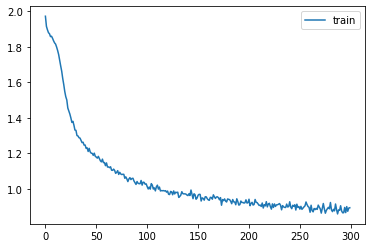

In [79]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 6


/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          B3    0.88235   0.30612   0.45455        49
          B2    0.76667   0.23232   0.35659        99
          B1    0.61053   0.42963   0.50435       135
          B0    0.86243   0.81095   0.83590       201
          S0    0.77872   0.88406   0.82805       207
          S1    0.61165   0.42282   0.50000       149
          S2    0.66250   0.46491   0.54639       114
          S3    0.81250   0.28261   0.41935        46

   micro avg    0.74641   0.57100   0.64703      1000
   macro avg    0.74842   0.47918   0.55565      1000
weighted avg    0.74014   0.57100   0.62116      1000
 samples avg    0.57100   0.57100   0.57100      1000

Confusion matrix, without normalization
[[ 43   3   3   0   0   0   0   0]
 [ 55  23  20   0   1   0   0   0]
 [ 54   4  58  18   1   0   0   0]
 [ 18   0  14 163   6   0   0   0]
 [  9   0   0   7 183   8   0   0]
 [ 37   0   0   1  41  63   7   0]
 [ 27   0   0   0   3  28  53   3]
 [  9   0 

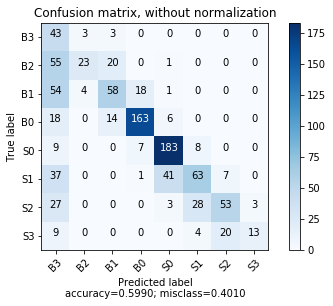

[3, 2, 4, 6, 2, 5, 5, 3, 4, 2, 4, 1, 5, 1, 3, 0, 2, 6, 3, 5, 6, 3, 3, 4, 2, 4, 6, 2, 4, 3, 1, 4, 2, 2, 4, 2, 3, 3, 6, 4, 5, 6, 3, 4, 3, 6, 3, 6, 3, 6, 5, 3, 1, 1, 4, 2, 4, 6, 6, 3, 3, 5, 6, 2, 4, 1, 5, 3, 4, 2, 4, 2, 3, 5, 4, 5, 4, 3, 4, 6, 6, 5, 5, 5, 3, 4, 3, 2, 4, 4, 3, 4, 5, 0, 2, 4, 6, 2, 3, 2, 0, 6, 2, 3, 4, 3, 2, 4, 3, 4, 2, 3, 5, 2, 5, 3, 1, 2, 4, 5, 4, 2, 3, 4, 4, 6, 2, 5, 4, 3, 3, 1, 3, 5, 3, 2, 7, 4, 2, 3, 2, 5, 2, 5, 1, 3, 4, 1, 3, 4, 2, 4, 6, 2, 5, 2, 3, 2, 1, 4, 4, 6, 5, 0, 3, 2, 7, 1, 4, 6, 5, 3, 3, 2, 4, 3, 1, 2, 3, 3, 0, 3, 0, 5, 4, 5, 0, 2, 5, 3, 1, 2, 4, 3, 3, 4, 1, 5, 4, 3, 3, 2, 0, 4, 4, 4, 4, 2, 2, 5, 5, 3, 4, 2, 1, 3, 6, 3, 6, 3, 4, 1, 7, 0, 4, 3, 1, 4, 2, 4, 5, 4, 3, 4, 3, 5, 4, 2, 0, 3, 1, 2, 4, 4, 1, 5, 3, 2, 3, 3, 3, 4, 4, 4, 5, 2, 3, 4, 3, 3, 4, 4, 2, 2, 2, 3, 4, 2, 4, 2, 0, 3, 6, 2, 5, 3, 6, 4, 4, 3, 3, 4, 1, 7, 4, 4, 5, 4, 3, 7, 2, 6, 1, 4, 2, 2, 4, 4, 4, 4, 4, 3, 4, 6, 4, 5, 4, 2, 6, 4, 4, 5, 3, 4, 2, 4, 4, 0, 2, 4, 1, 4, 5, 6, 4, 3, 2, 4, 5, 2, 3, 3, 5, 

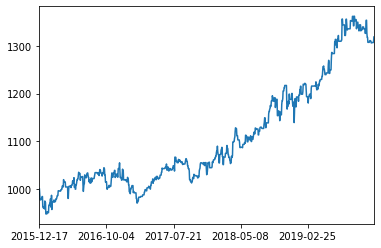

In [80]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 582us/step - loss: 2.0130 - accuracy: 0.2218
Epoch 2/300
3999/3999 [==============================] - 1s 185us/step - loss: 1.8438 - accuracy: 0.24460s - loss: 1.856
Epoch 3/300
3999/3999 [==============================] - 1s 189us/step - loss: 1.8061 - accuracy: 0.2596
Epoch 4/300
3999/3999 [==============================] - 1s 186us/step - loss: 1.7787 - accuracy: 0.2691
Epoch 5/300
3999/3999 [==============================] - 1s 190us/step - loss: 1.7521 - accuracy: 0.2691
Epoch 6/300
3999/3999 [==============================] - 1s 230us/step - loss: 1.7307 - accuracy: 0.2768
Epoch 7/300
3999/3999 [==============================] - 1s 261us/step - loss: 1.7079 - accuracy: 0.28210s - loss: 1.7034 - accuracy
Epoch 8/300
3999/3999 [==============================] - 1s 202us/step - loss: 1.6933 - accuracy: 0.29280s - loss: 1.6940 - ac
Epoch 9/300
3999/3999 [==============================] - 1s 190us/step - loss: 1.6775 - accura

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 249us/step - loss: 1.2617 - accuracy: 0.4546
Epoch 65/300
3999/3999 [==============================] - 1s 305us/step - loss: 1.2615 - accuracy: 0.4641
Epoch 66/300
3999/3999 [==============================] - 2s 551us/step - loss: 1.2437 - accuracy: 0.4739
Epoch 67/300
3999/3999 [==============================] - 2s 406us/step - loss: 1.2248 - accuracy: 0.4879
Epoch 68/300
3999/3999 [==============================] - 1s 315us/step - loss: 1.2403 - accuracy: 0.4739
Epoch 69/300
3999/3999 [==============================] - 2s 388us/step - loss: 1.2372 - accuracy: 0.4606
Epoch 70/300
3999/3999 [==============================] - 1s 292us/step - loss: 1.2159 - accuracy: 0.4861
Epoch 71/300
3999/3999 [==============================] - 1s 243us/step - loss: 1.2152 - accuracy: 0.4896
Epoch 72/300
3999/3999 [==============================] - 1s 337us/step - loss: 1.2104 - accuracy: 0.4866
Epoch 73/300
3999/3999 [==============================] - 1

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 326us/step - loss: 1.1061 - accuracy: 0.5279
Epoch 109/300
3999/3999 [==============================] - 1s 283us/step - loss: 1.0759 - accuracy: 0.5436
Epoch 110/300
3999/3999 [==============================] - 1s 282us/step - loss: 1.0746 - accuracy: 0.5406
Epoch 111/300
3999/3999 [==============================] - 1s 226us/step - loss: 1.0986 - accuracy: 0.5249
Epoch 112/300
3999/3999 [==============================] - 1s 192us/step - loss: 1.0964 - accuracy: 0.5299
Epoch 113/300
3999/3999 [==============================] - 1s 244us/step - loss: 1.0991 - accuracy: 0.5269
Epoch 114/300
3999/3999 [==============================] - 1s 250us/step - loss: 1.0817 - accuracy: 0.5461
Epoch 115/300
3999/3999 [==============================] - 1s 215us/step - loss: 1.0928 - accuracy: 0.5299
Epoch 116/300
3999/3999 [==============================] - 1s 243us/step - loss: 1.0869 - accuracy: 0.5399
Epoch 117/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 286us/step - loss: 1.0099 - accuracy: 0.5744
Epoch 143/300
3999/3999 [==============================] - 1s 326us/step - loss: 1.0253 - accuracy: 0.5659
Epoch 144/300
3999/3999 [==============================] - 1s 254us/step - loss: 1.0224 - accuracy: 0.56910s - loss:
Epoch 145/300
3999/3999 [==============================] - 1s 280us/step - loss: 1.0231 - accuracy: 0.5701
Epoch 146/300
3999/3999 [==============================] - 1s 306us/step - loss: 1.0084 - accuracy: 0.57710s - loss: 1.0060 - accuracy: 
Epoch 147/300
3999/3999 [==============================] - 1s 286us/step - loss: 1.0125 - accuracy: 0.5754
Epoch 148/300
3999/3999 [==============================] - 1s 279us/step - loss: 1.0222 - accuracy: 0.5679
Epoch 149/300
3999/3999 [==============================] - 1s 224us/step - loss: 1.0191 - accuracy: 0.5651
Epoch 150/300
3999/3999 [==============================] - 1s 290us/step - loss: 1.0066 - accuracy: 0.5789
Epoch 151/3

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 320us/step - loss: 0.9597 - accuracy: 0.6012
Epoch 193/300
3999/3999 [==============================] - 1s 236us/step - loss: 0.9578 - accuracy: 0.5949
Epoch 194/300
3999/3999 [==============================] - 1s 271us/step - loss: 0.9639 - accuracy: 0.5884
Epoch 195/300
3999/3999 [==============================] - 1s 297us/step - loss: 0.9631 - accuracy: 0.5906
Epoch 196/300
3999/3999 [==============================] - 1s 310us/step - loss: 0.9366 - accuracy: 0.5999
Epoch 197/300
3999/3999 [==============================] - 1s 277us/step - loss: 0.9358 - accuracy: 0.6114
Epoch 198/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.9550 - accuracy: 0.5956
Epoch 199/300
3999/3999 [==============================] - 1s 273us/step - loss: 0.9618 - accuracy: 0.5851
Epoch 200/300
3999/3999 [==============================] - 1s 263us/step - loss: 0.9446 - accuracy: 0.59390s - loss: 0.9486 - accu
Epoch 201/300
3999/3999 [==

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 487us/step - loss: 0.9072 - accuracy: 0.6142
Epoch 256/300
3999/3999 [==============================] - 2s 390us/step - loss: 0.9118 - accuracy: 0.6109
Epoch 257/300
3999/3999 [==============================] - 1s 331us/step - loss: 0.9134 - accuracy: 0.61970s - loss: 0.9160 - accura
Epoch 258/300
3999/3999 [==============================] - 2s 382us/step - loss: 0.9137 - accuracy: 0.61171s - loss: 0.9336 - accu - ETA: 0s - loss: 0.9224 - accura
Epoch 259/300
3999/3999 [==============================] - 1s 349us/step - loss: 0.8908 - accuracy: 0.6389
Epoch 260/300
3999/3999 [==============================] - 2s 377us/step - loss: 0.9038 - accuracy: 0.6179
Epoch 261/300
3999/3999 [==============================] - 1s 347us/step - loss: 0.9133 - accuracy: 0.6179
Epoch 262/300
3999/3999 [==============================] - 2s 380us/step - loss: 0.8984 - accuracy: 0.6257
Epoch 263/300
3999/3999 [==============================] - 1s 294us/step -

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 342us/step - loss: 0.8907 - accuracy: 0.6219
Epoch 267/300
3999/3999 [==============================] - 2s 387us/step - loss: 0.9155 - accuracy: 0.6209
Epoch 268/300
3999/3999 [==============================] - 2s 383us/step - loss: 0.9029 - accuracy: 0.6169
Epoch 269/300
3999/3999 [==============================] - 1s 365us/step - loss: 0.8985 - accuracy: 0.62640s - loss: 0.9078 - accu
Epoch 270/300
3999/3999 [==============================] - 1s 324us/step - loss: 0.9101 - accuracy: 0.6279
Epoch 271/300
3999/3999 [==============================] - 2s 393us/step - loss: 0.8927 - accuracy: 0.6222
Epoch 272/300
3999/3999 [==============================] - 2s 409us/step - loss: 0.9228 - accuracy: 0.6192
Epoch 273/300
3999/3999 [==============================] - 1s 355us/step - loss: 0.9079 - accuracy: 0.6209
Epoch 274/300
3999/3999 [==============================] - 1s 360us/step - loss: 0.9192 - accuracy: 0.6129
Epoch 275/300
3999/3999 [==

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.62 - 2s 470us/step - loss: 0.8875 - accuracy: 0.6264
Epoch 292/300
3999/3999 [==============================] - 2s 556us/step - loss: 0.8777 - accuracy: 0.63770s - loss: 0.9 - ETA: 0s - loss: 0.8810 - accuracy
Epoch 293/300
 256/3999 [>.............................] - ETA: 9s - loss: 0.8186 - accuracy: 0.6797 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.

3999/3999 [==============================] - 4s 1ms/step - loss: 0.8958 - accuracy: 0.6129
Epoch 294/300
3999/3999 [==============================] - 3s 681us/step - loss: 0.9112 - accuracy: 0.61970s - loss: 0.9175 - accu
Epoch 295/300
3999/3999 [==============================] - 2s 537us/step - loss: 0.9145 - accuracy: 0.6144
Epoch 296/300
3999/3999 [==============================] - 3s 641us/step - loss: 0.8813 - accuracy: 0.6317
Epoch 297/300
3999/3999 [==============================] - 3s 667us/step - loss: 0.8768 - accuracy: 0.6289
Epoch 298/300
3999/3999 [==============================] - 2s 596us/step - loss: 0.9160 - accuracy: 0.6269
Epoch 299/300
3999/3999 [==============================] - 2s 524us/step - loss: 0.8693 - accuracy: 0.6342
Epoch 300/300
3999/3999 [==============================] - 2s 516us/step - loss: 0.8868 - accuracy: 0.6249


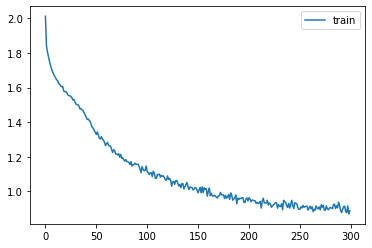

In [81]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 8


/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          B3    0.89286   0.51020   0.64935        49
          B2    0.68750   0.11111   0.19130        99
          B1    0.60331   0.54074   0.57031       135
          B0    0.84375   0.67164   0.74792       201
          S0    0.79235   0.70048   0.74359       207
          S1    0.62727   0.46309   0.53282       149
          S2    0.63208   0.58772   0.60909       114
          S3    0.81818   0.39130   0.52941        46

   micro avg    0.72788   0.54300   0.62199      1000
   macro avg    0.73716   0.49704   0.57173      1000
weighted avg    0.73003   0.54300   0.60518      1000
 samples avg    0.54300   0.54300   0.54300      1000

Confusion matrix, without normalization
[[ 43   3   2   1   0   0   0   0]
 [ 61  11  25   1   1   0   0   0]
 [ 41   2  73  18   1   0   0   0]
 [ 21   0  21 135  24   0   0   0]
 [ 34   0   0   4 145  24   0   0]
 [ 47   0   0   1  12  69  20   0]
 [ 26   0   0   0   0  17  67   4]
 [  9   0 

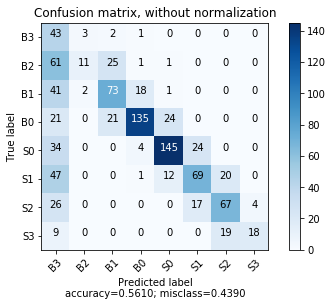

[3, 2, 4, 6, 2, 6, 5, 2, 4, 2, 5, 2, 5, 1, 3, 0, 2, 6, 3, 6, 6, 2, 3, 5, 2, 5, 6, 2, 5, 2, 0, 5, 2, 2, 4, 2, 3, 2, 6, 4, 5, 6, 3, 5, 2, 6, 3, 7, 3, 6, 5, 3, 1, 0, 4, 2, 4, 6, 6, 2, 2, 5, 6, 3, 4, 1, 5, 4, 5, 3, 5, 3, 3, 5, 4, 6, 4, 3, 4, 6, 7, 6, 5, 5, 2, 5, 3, 2, 4, 5, 2, 4, 6, 0, 2, 4, 6, 2, 3, 1, 0, 6, 2, 3, 5, 3, 2, 4, 3, 5, 2, 2, 6, 2, 5, 3, 1, 2, 5, 5, 4, 2, 3, 4, 4, 7, 2, 6, 4, 3, 3, 1, 2, 5, 2, 2, 6, 4, 2, 3, 2, 5, 2, 5, 0, 4, 4, 2, 3, 4, 2, 4, 6, 2, 5, 2, 3, 2, 1, 4, 5, 6, 5, 0, 2, 3, 7, 1, 4, 7, 5, 3, 4, 2, 4, 3, 1, 2, 3, 3, 0, 3, 0, 6, 4, 6, 1, 2, 5, 2, 1, 2, 4, 3, 3, 4, 1, 6, 4, 3, 3, 2, 0, 4, 3, 4, 5, 2, 2, 5, 6, 3, 5, 2, 2, 3, 6, 3, 6, 3, 4, 1, 6, 0, 5, 2, 0, 4, 2, 4, 5, 5, 3, 4, 3, 5, 4, 2, 0, 4, 1, 2, 5, 4, 1, 5, 3, 2, 2, 3, 3, 4, 4, 4, 5, 2, 3, 5, 3, 3, 4, 5, 1, 2, 3, 3, 5, 2, 5, 2, 0, 3, 6, 1, 6, 4, 6, 5, 5, 3, 3, 4, 0, 7, 4, 4, 5, 5, 3, 7, 2, 6, 0, 5, 2, 2, 4, 4, 4, 4, 4, 3, 4, 6, 5, 5, 4, 2, 5, 4, 5, 5, 3, 4, 2, 4, 4, 0, 2, 4, 2, 5, 5, 6, 4, 2, 2, 4, 5, 2, 3, 3, 6, 

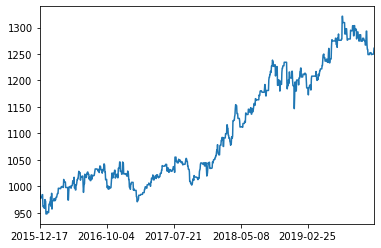

In [82]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 6s 1ms/step - loss: 5.5723 - accuracy: 0.1743
Epoch 2/300
3999/3999 [==============================] - 2s 385us/step - loss: 2.0582 - accuracy: 0.2071
Epoch 3/300
3999/3999 [==============================] - ETA: 0s - loss: 1.9787 - accuracy: 0.22 - 2s 466us/step - loss: 1.9765 - accuracy: 0.2236
Epoch 4/300
3999/3999 [==============================] - 2s 608us/step - loss: 1.9480 - accuracy: 0.2258
Epoch 5/300
3999/3999 [==============================] - 1s 347us/step - loss: 1.9178 - accuracy: 0.2353
Epoch 6/300
3999/3999 [==============================] - 2s 420us/step - loss: 1.9052 - accuracy: 0.2378
Epoch 7/300
3999/3999 [==============================] - 1s 301us/step - loss: 1.9163 - accuracy: 0.2408
Epoch 8/300
3999/3999 [==============================] - 2s 375us/step - loss: 1.8978 - accuracy: 0.2313
Epoch 9/300
 480/3999 [==>...........................] - ETA: 3s - loss: 1.8923 - accuracy: 0.2479

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 494us/step - loss: 1.8907 - accuracy: 0.2398
Epoch 10/300
3999/3999 [==============================] - 2s 406us/step - loss: 1.8825 - accuracy: 0.2438
Epoch 11/300
1216/3999 [========>.....................] - ETA: 0s - loss: 1.9143 - accuracy: 0.2286

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 412us/step - loss: 1.8842 - accuracy: 0.2381
Epoch 12/300
3999/3999 [==============================] - 2s 393us/step - loss: 1.8683 - accuracy: 0.2441
Epoch 13/300
3999/3999 [==============================] - 1s 372us/step - loss: 1.8619 - accuracy: 0.2443
Epoch 14/300
3999/3999 [==============================] - 2s 476us/step - loss: 1.8610 - accuracy: 0.2496
Epoch 15/300
3999/3999 [==============================] - 1s 360us/step - loss: 1.8529 - accuracy: 0.2551
Epoch 16/300
3999/3999 [==============================] - 1s 373us/step - loss: 1.8500 - accuracy: 0.2561
Epoch 17/300
3999/3999 [==============================] - 1s 337us/step - loss: 1.8462 - accuracy: 0.2488
Epoch 18/300
3999/3999 [==============================] - 1s 373us/step - loss: 1.8303 - accuracy: 0.2591
Epoch 19/300
3999/3999 [==============================] - 2s 396us/step - loss: 1.8398 - accuracy: 0.25914s - los
Epoch 20/300
3999/3999 [===========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 445us/step - loss: 1.7501 - accuracy: 0.2743
Epoch 45/300
3999/3999 [==============================] - 1s 348us/step - loss: 1.7518 - accuracy: 0.2768
Epoch 46/300
3999/3999 [==============================] - 1s 291us/step - loss: 1.7456 - accuracy: 0.2828
Epoch 47/300
3999/3999 [==============================] - 1s 310us/step - loss: 1.7473 - accuracy: 0.28530s - loss: 1.7544 - accu
Epoch 48/300
3999/3999 [==============================] - 1s 303us/step - loss: 1.7481 - accuracy: 0.2831
Epoch 49/300
3999/3999 [==============================] - 1s 285us/step - loss: 1.7457 - accuracy: 0.27530s - loss: 1.7484 - ac
Epoch 50/300
3999/3999 [==============================] - 1s 283us/step - loss: 1.7314 - accuracy: 0.2906
Epoch 51/300
3999/3999 [==============================] - 1s 325us/step - loss: 1.7355 - accuracy: 0.2736
Epoch 52/300
3999/3999 [==============================] - 1s 341us/step - loss: 1.7307 - accuracy: 0.2843
Epoch 53/300


3999/3999 [==============================] - 1s 309us/step - loss: 1.6367 - accuracy: 0.3096
Epoch 119/300
3999/3999 [==============================] - 1s 264us/step - loss: 1.6207 - accuracy: 0.3231
Epoch 120/300
3999/3999 [==============================] - 1s 245us/step - loss: 1.6198 - accuracy: 0.3213
Epoch 121/300
3999/3999 [==============================] - 1s 280us/step - loss: 1.6236 - accuracy: 0.3123
Epoch 122/300
3999/3999 [==============================] - 1s 301us/step - loss: 1.6087 - accuracy: 0.3193
Epoch 123/300
3999/3999 [==============================] - 1s 294us/step - loss: 1.6351 - accuracy: 0.3143
Epoch 124/300
3999/3999 [==============================] - 1s 311us/step - loss: 1.6430 - accuracy: 0.3166
Epoch 125/300
3999/3999 [==============================] - 1s 260us/step - loss: 1.6372 - accuracy: 0.3123
Epoch 126/300
3999/3999 [==============================] - 1s 342us/step - loss: 1.6324 - accuracy: 0.30930s - loss: 1.6321 
Epoch 127/300
3999/3999 [========

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 299us/step - loss: 1.6223 - accuracy: 0.3161
Epoch 131/300
3999/3999 [==============================] - 1s 291us/step - loss: 1.5986 - accuracy: 0.3313
Epoch 132/300
3999/3999 [==============================] - 1s 330us/step - loss: 1.6400 - accuracy: 0.3101
Epoch 133/300
3999/3999 [==============================] - 1s 280us/step - loss: 1.6061 - accuracy: 0.3351
Epoch 134/300
3999/3999 [==============================] - 1s 291us/step - loss: 1.6287 - accuracy: 0.3143
Epoch 135/300
3999/3999 [==============================] - 1s 331us/step - loss: 1.6143 - accuracy: 0.32610s - loss: 1.6196 - accuracy: 0.
Epoch 136/300
3999/3999 [==============================] - 2s 385us/step - loss: 1.6127 - accuracy: 0.3206
Epoch 137/300
3999/3999 [==============================] - 1s 232us/step - loss: 1.6121 - accuracy: 0.3266
Epoch 138/300
3999/3999 [==============================] - 1s 232us/step - loss: 1.6288 - accuracy: 0.3163
Epoch 139/300
 256/

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 290us/step - loss: 1.6057 - accuracy: 0.3183
Epoch 140/300
3999/3999 [==============================] - 1s 274us/step - loss: 1.6156 - accuracy: 0.3228
Epoch 141/300
3999/3999 [==============================] - 1s 210us/step - loss: 1.5819 - accuracy: 0.3341
Epoch 142/300
3999/3999 [==============================] - 1s 330us/step - loss: 1.6134 - accuracy: 0.3111
Epoch 143/300
3999/3999 [==============================] - 1s 256us/step - loss: 1.6592 - accuracy: 0.31580s - loss: 1.6496 - 
Epoch 144/300
3999/3999 [==============================] - 1s 315us/step - loss: 1.6144 - accuracy: 0.3168
Epoch 145/300
3999/3999 [==============================] - 1s 297us/step - loss: 1.6131 - accuracy: 0.3153
Epoch 146/300
3999/3999 [==============================] - 1s 299us/step - loss: 1.6236 - accuracy: 0.3178
Epoch 147/300
 640/3999 [===>..........................] - ETA: 1s - loss: 1.6546 - accuracy: 0.3219

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 321us/step - loss: 1.6007 - accuracy: 0.3281
Epoch 148/300
3999/3999 [==============================] - 1s 313us/step - loss: 1.6043 - accuracy: 0.3196
Epoch 149/300
3999/3999 [==============================] - 1s 260us/step - loss: 1.6219 - accuracy: 0.3251
Epoch 150/300
3999/3999 [==============================] - 1s 312us/step - loss: 1.6111 - accuracy: 0.3226
Epoch 151/300
3999/3999 [==============================] - 1s 288us/step - loss: 1.5972 - accuracy: 0.3236
Epoch 152/300
3999/3999 [==============================] - 1s 271us/step - loss: 1.6247 - accuracy: 0.32710s - loss: 1.6415 
Epoch 153/300
3999/3999 [==============================] - 1s 279us/step - loss: 1.6148 - accuracy: 0.3226
Epoch 154/300
3999/3999 [==============================] - 1s 304us/step - loss: 1.5977 - accuracy: 0.3248
Epoch 155/300
3999/3999 [==============================] - 1s 256us/step - loss: 1.5996 - accuracy: 0.3296
Epoch 156/300
3999/3999 [========

3999/3999 [==============================] - 1s 266us/step - loss: 1.5849 - accuracy: 0.3268
Epoch 223/300
3999/3999 [==============================] - 1s 298us/step - loss: 1.5494 - accuracy: 0.3363
Epoch 224/300
3999/3999 [==============================] - 1s 277us/step - loss: 1.5609 - accuracy: 0.3448
Epoch 225/300
3999/3999 [==============================] - 1s 291us/step - loss: 1.5479 - accuracy: 0.3463
Epoch 226/300
3999/3999 [==============================] - 1s 296us/step - loss: 1.5866 - accuracy: 0.3276
Epoch 227/300
3999/3999 [==============================] - 1s 289us/step - loss: 1.5718 - accuracy: 0.33660s - loss: 1.5710 
Epoch 228/300
3999/3999 [==============================] - 1s 256us/step - loss: 1.5868 - accuracy: 0.3318
Epoch 229/300
3999/3999 [==============================] - 1s 334us/step - loss: 1.5865 - accuracy: 0.3331
Epoch 230/300
3999/3999 [==============================] - 1s 292us/step - loss: 1.5470 - accuracy: 0.3416
Epoch 231/300
3999/3999 [========

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 354us/step - loss: 1.5448 - accuracy: 0.3493
Epoch 248/300
3999/3999 [==============================] - 1s 264us/step - loss: 1.5674 - accuracy: 0.3376
Epoch 249/300
3999/3999 [==============================] - 1s 258us/step - loss: 1.5545 - accuracy: 0.3508
Epoch 250/300
3999/3999 [==============================] - 1s 259us/step - loss: 1.5414 - accuracy: 0.3476
Epoch 251/300
3999/3999 [==============================] - 1s 307us/step - loss: 1.5630 - accuracy: 0.3426
Epoch 252/300
3999/3999 [==============================] - 1s 296us/step - loss: 1.5558 - accuracy: 0.33780s - loss: 1.5664 - accuracy
Epoch 253/300
3999/3999 [==============================] - 1s 355us/step - loss: 1.5515 - accuracy: 0.35161s - loss: - ETA: 0s - loss: 1.5436 - accuracy: 
Epoch 254/300
3999/3999 [==============================] - 1s 321us/step - loss: 1.5547 - accuracy: 0.3416
Epoch 255/300
3999/3999 [==============================] - 1s 364us/step - loss: 1

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 280us/step - loss: 1.5208 - accuracy: 0.3488
Epoch 263/300
3999/3999 [==============================] - 2s 448us/step - loss: 1.5502 - accuracy: 0.34630s - loss: 1.5573 - accura
Epoch 264/300
3999/3999 [==============================] - 1s 332us/step - loss: 1.5438 - accuracy: 0.34411s - loss: 1.5884 - accuracy: 0. - ETA: 1s - loss: 1
Epoch 265/300
3999/3999 [==============================] - 1s 330us/step - loss: 1.5392 - accuracy: 0.3588
Epoch 266/300
3999/3999 [==============================] - 1s 338us/step - loss: 1.5543 - accuracy: 0.3418
Epoch 267/300
3999/3999 [==============================] - 1s 349us/step - loss: 1.5378 - accuracy: 0.3528
Epoch 268/300
3999/3999 [==============================] - 1s 330us/step - loss: 1.5110 - accuracy: 0.3636
Epoch 269/300
3999/3999 [==============================] - 5s 1ms/step - loss: 1.5385 - accuracy: 0.3498
Epoch 270/300
3999/3999 [==============================] - 2s 391us/step - loss: 1

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 339us/step - loss: 1.5157 - accuracy: 0.3548
Epoch 275/300
3999/3999 [==============================] - 1s 367us/step - loss: 1.5409 - accuracy: 0.3503
Epoch 276/300
3999/3999 [==============================] - 2s 501us/step - loss: 1.5130 - accuracy: 0.35612s -
Epoch 277/300
3999/3999 [==============================] - 2s 554us/step - loss: 1.5307 - accuracy: 0.34830s - loss: 1.5249 - ac
Epoch 278/300
3999/3999 [==============================] - 1s 326us/step - loss: 1.5336 - accuracy: 0.3498
Epoch 279/300
3999/3999 [==============================] - 2s 393us/step - loss: 1.5504 - accuracy: 0.3563
Epoch 280/300
3999/3999 [==============================] - 1s 282us/step - loss: 1.5237 - accuracy: 0.3586
Epoch 281/300
3999/3999 [==============================] - 2s 560us/step - loss: 1.5424 - accuracy: 0.3438
Epoch 282/300
3999/3999 [==============================] - 2s 399us/step - loss: 1.5426 - accuracy: 0.3523
Epoch 283/300
3999/3999 [

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 377us/step - loss: 1.5314 - accuracy: 0.3533
Epoch 292/300
3999/3999 [==============================] - 2s 474us/step - loss: 1.5297 - accuracy: 0.3626
Epoch 293/300
3999/3999 [==============================] - 2s 440us/step - loss: 1.5288 - accuracy: 0.3568
Epoch 294/300
3999/3999 [==============================] - 1s 352us/step - loss: 1.5471 - accuracy: 0.3406
Epoch 295/300
3999/3999 [==============================] - 2s 450us/step - loss: 1.5269 - accuracy: 0.3623
Epoch 296/300
3999/3999 [==============================] - 2s 377us/step - loss: 1.5111 - accuracy: 0.3593
Epoch 297/300
3999/3999 [==============================] - 2s 388us/step - loss: 1.5118 - accuracy: 0.3696
Epoch 298/300
3999/3999 [==============================] - 2s 487us/step - loss: 1.5036 - accuracy: 0.3591
Epoch 299/300
3999/3999 [==============================] - 2s 523us/step - loss: 1.5337 - accuracy: 0.35660s - loss: 1.5543 - 
Epoch 300/300
3999/3999 [======

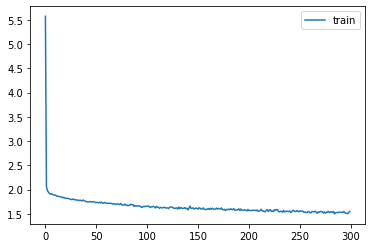

In [83]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 11


/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          B3    0.87500   0.28571   0.43077        49
          B2    0.00000   0.00000   0.00000        99
          B1    0.00000   0.00000   0.00000       135
          B0    0.00000   0.00000   0.00000       201
          S0    0.50000   0.00483   0.00957       207
          S1    0.00000   0.00000   0.00000       149
          S2    0.00000   0.00000   0.00000       114
          S3    0.66667   0.04348   0.08163        46

   micro avg    0.56667   0.01700   0.03301      1000
   macro avg    0.25521   0.04175   0.06525      1000
weighted avg    0.17704   0.01700   0.02684      1000
 samples avg    0.01700   0.01700   0.01700      1000

Confusion matrix, without normalization
[[ 46   3   0   0   0   0   0   0]
 [ 99   0   0   0   0   0   0   0]
 [134   0   0   1   0   0   0   0]
 [201   0   0   0   0   0   0   0]
 [206   0   0   0   1   0   0   0]
 [148   0   0   0   1   0   0   0]
 [113   0   0   0   0   0   0   1]
 [ 39   0 

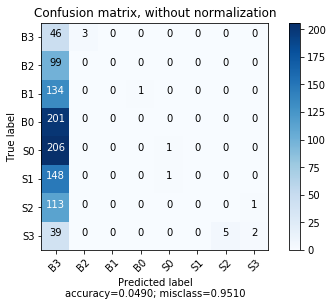

[4, 3, 4, 6, 3, 5, 6, 3, 4, 2, 5, 3, 4, 1, 4, 0, 3, 5, 3, 6, 6, 3, 1, 6, 4, 4, 6, 1, 4, 0, 0, 6, 3, 4, 4, 3, 3, 4, 6, 4, 4, 5, 4, 5, 3, 4, 3, 5, 3, 6, 4, 2, 3, 0, 5, 3, 4, 5, 5, 4, 4, 4, 5, 4, 6, 3, 5, 4, 6, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 6, 6, 5, 5, 4, 3, 4, 4, 3, 4, 4, 3, 2, 4, 0, 4, 3, 5, 3, 4, 1, 0, 5, 4, 1, 4, 2, 3, 3, 2, 3, 3, 4, 5, 3, 4, 4, 1, 3, 4, 5, 3, 4, 4, 4, 4, 5, 4, 4, 4, 6, 1, 2, 4, 4, 4, 3, 6, 4, 3, 4, 3, 4, 4, 4, 1, 4, 4, 3, 1, 6, 2, 4, 5, 3, 5, 3, 4, 4, 2, 4, 4, 5, 5, 2, 3, 3, 6, 2, 4, 7, 7, 2, 1, 3, 3, 4, 1, 3, 4, 4, 0, 6, 3, 1, 4, 5, 2, 4, 5, 2, 1, 3, 4, 2, 1, 6, 3, 4, 4, 4, 4, 1, 0, 4, 6, 4, 4, 2, 3, 4, 6, 4, 6, 1, 3, 2, 4, 5, 5, 4, 4, 0, 7, 0, 4, 2, 1, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 4, 1, 2, 4, 4, 3, 4, 3, 4, 3, 3, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 1, 3, 4, 4, 5, 3, 4, 1, 0, 4, 4, 1, 4, 4, 6, 5, 4, 4, 4, 4, 0, 7, 4, 3, 6, 4, 2, 6, 3, 4, 1, 4, 1, 2, 4, 1, 5, 4, 3, 3, 3, 4, 5, 4, 4, 3, 6, 4, 4, 6, 3, 3, 4, 4, 6, 0, 3, 2, 3, 5, 4, 4, 4, 3, 2, 4, 6, 4, 3, 4, 5, 

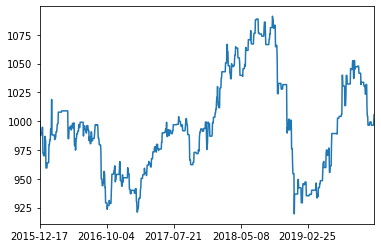

In [84]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 6s 1ms/step - loss: 1.9735 - accuracy: 0.2165
Epoch 2/300
3996/3996 [==============================] - 1s 318us/step - loss: 1.8452 - accuracy: 0.2447
Epoch 3/300
3996/3996 [==============================] - 1s 366us/step - loss: 1.8042 - accuracy: 0.2693
Epoch 4/300
3996/3996 [==============================] - 1s 339us/step - loss: 1.7732 - accuracy: 0.2595
Epoch 5/300
3996/3996 [==============================] - 2s 384us/step - loss: 1.7616 - accuracy: 0.2743
Epoch 6/300
3996/3996 [==============================] - 2s 494us/step - loss: 1.7357 - accuracy: 0.2650
Epoch 7/300
3996/3996 [==============================] - 2s 558us/step - loss: 1.7326 - accuracy: 0.2725
Epoch 8/300
3996/3996 [==============================] - 3s 639us/step - loss: 1.7228 - accuracy: 0.2808
Epoch 9/300
3996/3996 [==============================] - 2s 452us/step - loss: 1.7180 - accuracy: 0.2903
Epoch 10/300
3996/3996 [==============================] -

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 276us/step - loss: 1.6621 - accuracy: 0.3048
Epoch 37/300
3996/3996 [==============================] - 2s 390us/step - loss: 1.6512 - accuracy: 0.3158
Epoch 38/300
3996/3996 [==============================] - 2s 384us/step - loss: 1.6572 - accuracy: 0.3023
Epoch 39/300
3996/3996 [==============================] - 2s 516us/step - loss: 1.6571 - accuracy: 0.3103
Epoch 40/300
3996/3996 [==============================] - 2s 422us/step - loss: 1.6591 - accuracy: 0.3001
Epoch 41/300
3996/3996 [==============================] - 2s 486us/step - loss: 1.6455 - accuracy: 0.3201
Epoch 42/300
3996/3996 [==============================] - 2s 542us/step - loss: 1.6541 - accuracy: 0.3051
Epoch 43/300
3996/3996 [==============================] - 2s 550us/step - loss: 1.6518 - accuracy: 0.3031
Epoch 44/300
3996/3996 [==============================] - 2s 531us/step - loss: 1.6463 - accuracy: 0.32110s - loss: 1.6525 - accu
Epoch 45/300
3996/3996 [===========

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 444us/step - loss: 1.5992 - accuracy: 0.3286
Epoch 95/300
3996/3996 [==============================] - 1s 329us/step - loss: 1.6001 - accuracy: 0.3323
Epoch 96/300
3996/3996 [==============================] - 2s 457us/step - loss: 1.6002 - accuracy: 0.3291
Epoch 97/300
3996/3996 [==============================] - 2s 429us/step - loss: 1.5986 - accuracy: 0.3336
Epoch 98/300
3996/3996 [==============================] - 1s 336us/step - loss: 1.6091 - accuracy: 0.3243
Epoch 99/300
3996/3996 [==============================] - 2s 465us/step - loss: 1.5954 - accuracy: 0.3246
Epoch 100/300
3996/3996 [==============================] - 2s 446us/step - loss: 1.5900 - accuracy: 0.3326
Epoch 101/300
3996/3996 [==============================] - 1s 355us/step - loss: 1.5985 - accuracy: 0.3221
Epoch 102/300
3996/3996 [==============================] - 2s 490us/step - loss: 1.5906 - accuracy: 0.3316
Epoch 103/300
3996/3996 [==============================]

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 372us/step - loss: 1.5567 - accuracy: 0.3441
Epoch 136/300
3996/3996 [==============================] - 2s 437us/step - loss: 1.5604 - accuracy: 0.3443
Epoch 137/300
3996/3996 [==============================] - 2s 417us/step - loss: 1.5666 - accuracy: 0.3438
Epoch 138/300
3996/3996 [==============================] - 1s 287us/step - loss: 1.5566 - accuracy: 0.3478
Epoch 139/300
3996/3996 [==============================] - 1s 280us/step - loss: 1.5541 - accuracy: 0.3366
Epoch 140/300
3996/3996 [==============================] - 1s 353us/step - loss: 1.5635 - accuracy: 0.3396
Epoch 141/300
3996/3996 [==============================] - 1s 286us/step - loss: 1.5580 - accuracy: 0.3456
Epoch 142/300
3996/3996 [==============================] - 2s 407us/step - loss: 1.5498 - accuracy: 0.3496
Epoch 143/300
3996/3996 [==============================] - 1s 292us/step - loss: 1.5496 - accuracy: 0.3519
Epoch 144/300
3996/3996 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 346us/step - loss: 1.5187 - accuracy: 0.3569
Epoch 207/300
3996/3996 [==============================] - 1s 261us/step - loss: 1.5185 - accuracy: 0.3551
Epoch 208/300
3996/3996 [==============================] - 1s 309us/step - loss: 1.5177 - accuracy: 0.3473
Epoch 209/300
3996/3996 [==============================] - 1s 282us/step - loss: 1.5114 - accuracy: 0.3651
Epoch 210/300
3996/3996 [==============================] - 1s 259us/step - loss: 1.5044 - accuracy: 0.3609
Epoch 211/300
3996/3996 [==============================] - 1s 317us/step - loss: 1.5111 - accuracy: 0.3601
Epoch 212/300
3996/3996 [==============================] - 1s 248us/step - loss: 1.5181 - accuracy: 0.3564
Epoch 213/300
3996/3996 [==============================] - 1s 260us/step - loss: 1.5060 - accuracy: 0.3639
Epoch 214/300
3996/3996 [==============================] - 1s 280us/step - loss: 1.5080 - accuracy: 0.3659
Epoch 215/300
3996/3996 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 370us/step - loss: 1.5168 - accuracy: 0.3601
Epoch 241/300
3996/3996 [==============================] - 2s 436us/step - loss: 1.5069 - accuracy: 0.3591
Epoch 242/300
3996/3996 [==============================] - 1s 351us/step - loss: 1.4912 - accuracy: 0.3729
Epoch 243/300
3996/3996 [==============================] - 1s 339us/step - loss: 1.5130 - accuracy: 0.3634
Epoch 244/300
3996/3996 [==============================] - 1s 365us/step - loss: 1.4958 - accuracy: 0.3751
Epoch 245/300
3996/3996 [==============================] - 1s 347us/step - loss: 1.5079 - accuracy: 0.3551
Epoch 246/300
3996/3996 [==============================] - 1s 259us/step - loss: 1.5119 - accuracy: 0.3564
Epoch 247/300
3996/3996 [==============================] - 1s 218us/step - loss: 1.5042 - accuracy: 0.3784
Epoch 248/300
3996/3996 [==============================] - 1s 363us/step - loss: 1.5011 - accuracy: 0.3711
Epoch 249/300
3996/3996 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 408us/step - loss: 1.5109 - accuracy: 0.3669
Epoch 279/300
3996/3996 [==============================] - 1s 293us/step - loss: 1.4933 - accuracy: 0.3616
Epoch 280/300
3996/3996 [==============================] - 1s 314us/step - loss: 1.5046 - accuracy: 0.36710s - loss: 1.5159 - accu
Epoch 281/300
3996/3996 [==============================] - 1s 344us/step - loss: 1.4999 - accuracy: 0.3664
Epoch 282/300
3996/3996 [==============================] - 1s 315us/step - loss: 1.4944 - accuracy: 0.3699
Epoch 283/300
3996/3996 [==============================] - 1s 340us/step - loss: 1.4932 - accuracy: 0.3636
Epoch 284/300
3996/3996 [==============================] - 1s 284us/step - loss: 1.4910 - accuracy: 0.3739
Epoch 285/300
3996/3996 [==============================] - 1s 334us/step - loss: 1.4901 - accuracy: 0.3619
Epoch 286/300
3996/3996 [==============================] - 1s 285us/step - loss: 1.4926 - accuracy: 0.3734
Epoch 287/300
3996/3996 [==

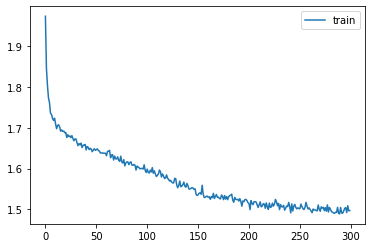

In [85]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.87500   0.15909   0.26923        44
          B2    0.00000   0.00000   0.00000       105
          B1    0.00000   0.00000   0.00000       127
          B0    0.00000   0.00000   0.00000       203
          S0    1.00000   0.00415   0.00826       241
          S1    0.00000   0.00000   0.00000       142
          S2    1.00000   0.00990   0.01961       101
          S3    0.58333   0.18919   0.28571        37

   micro avg    0.72727   0.01600   0.03131      1000
   macro avg    0.43229   0.04529   0.07285      1000
weighted avg    0.40208   0.01600   0.02639      1000
 samples avg    0.01600   0.01600   0.01600      1000

Confusion matrix, without normalization
[[ 44   0   0   0   0   0   0   0]
 [105   0   0   0   0   0   0   0]
 [127   0   0   0   0   0   0   0]
 [203   0   0   0   0   0   0   0]
 [239   0   0   0   1   0   0   1]
 [140   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


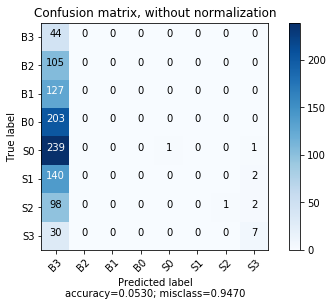

[3, 3, 1, 5, 5, 4, 0, 3, 4, 4, 3, 4, 2, 4, 2, 1, 1, 3, 4, 3, 4, 2, 1, 3, 5, 4, 3, 3, 3, 4, 4, 3, 4, 4, 3, 6, 1, 5, 5, 3, 4, 4, 5, 4, 6, 5, 3, 4, 7, 4, 5, 1, 3, 1, 3, 4, 4, 5, 4, 3, 3, 3, 3, 4, 4, 7, 3, 3, 7, 3, 6, 5, 4, 2, 3, 5, 4, 3, 0, 4, 4, 3, 4, 3, 4, 6, 6, 4, 4, 4, 4, 5, 4, 4, 1, 4, 6, 6, 3, 3, 2, 4, 1, 3, 6, 3, 3, 4, 6, 5, 6, 3, 3, 1, 3, 3, 5, 1, 3, 4, 5, 4, 4, 4, 3, 4, 2, 4, 2, 3, 3, 6, 1, 2, 4, 4, 6, 6, 3, 3, 5, 1, 3, 5, 4, 3, 5, 3, 3, 3, 1, 3, 3, 4, 6, 2, 6, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 7, 5, 3, 1, 6, 6, 6, 6, 4, 5, 5, 4, 1, 4, 4, 3, 3, 1, 2, 1, 5, 6, 4, 4, 4, 5, 4, 5, 4, 3, 5, 1, 2, 4, 3, 4, 4, 6, 3, 4, 3, 6, 4, 4, 6, 4, 2, 4, 1, 6, 4, 6, 1, 3, 4, 4, 1, 3, 3, 6, 4, 2, 2, 4, 4, 5, 3, 3, 6, 4, 4, 2, 6, 3, 4, 4, 2, 6, 3, 4, 4, 3, 6, 5, 5, 1, 4, 4, 6, 2, 6, 1, 5, 1, 3, 4, 4, 4, 4, 3, 4, 4, 2, 1, 3, 5, 3, 5, 6, 4, 6, 0, 3, 3, 7, 4, 3, 3, 1, 5, 3, 6, 4, 2, 5, 1, 4, 2, 3, 0, 1, 4, 3, 3, 4, 4, 4, 4, 6, 5, 6, 4, 7, 0, 4, 2, 1, 4, 0, 2, 4, 2, 3, 1, 4, 2, 3, 4, 3, 6, 6, 5, 5, 3, 4, 4, 

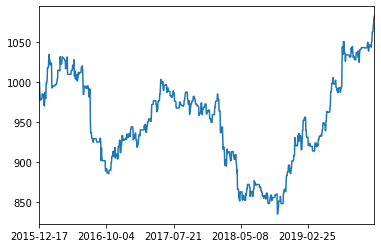

In [86]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 4s 1ms/step - loss: 1.9056 - accuracy: 0.2390
Epoch 2/300
3996/3996 [==============================] - 1s 304us/step - loss: 1.7728 - accuracy: 0.2590
Epoch 3/300
3996/3996 [==============================] - 1s 286us/step - loss: 1.7359 - accuracy: 0.2728
Epoch 4/300
3996/3996 [==============================] - 1s 374us/step - loss: 1.7068 - accuracy: 0.2915
Epoch 5/300
3996/3996 [==============================] - 2s 396us/step - loss: 1.7002 - accuracy: 0.2855
Epoch 6/300
3996/3996 [==============================] - 1s 374us/step - loss: 1.6847 - accuracy: 0.2863
Epoch 7/300
3996/3996 [==============================] - 1s 350us/step - loss: 1.6739 - accuracy: 0.3026
Epoch 8/300
3996/3996 [==============================] - 2s 380us/step - loss: 1.6656 - accuracy: 0.2838
Epoch 9/300
3996/3996 [==============================] - 1s 318us/step - loss: 1.6523 - accuracy: 0.3078
Epoch 10/300
3996/3996 [==============================] -

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 357us/step - loss: 1.3245 - accuracy: 0.4442
Epoch 38/300
3996/3996 [==============================] - 1s 330us/step - loss: 1.2852 - accuracy: 0.4565
Epoch 39/300
3996/3996 [==============================] - 1s 299us/step - loss: 1.2711 - accuracy: 0.4505
Epoch 40/300
3996/3996 [==============================] - 1s 313us/step - loss: 1.2635 - accuracy: 0.46220s - loss: 1.248
Epoch 41/300
3996/3996 [==============================] - 1s 329us/step - loss: 1.2622 - accuracy: 0.4710
Epoch 42/300
3996/3996 [==============================] - 1s 298us/step - loss: 1.2203 - accuracy: 0.4855
Epoch 43/300
 608/3996 [===>..........................] - ETA: 1s - loss: 1.2280 - accuracy: 0.4704 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 413us/step - loss: 1.2231 - accuracy: 0.4757
Epoch 44/300
3996/3996 [==============================] - 1s 264us/step - loss: 1.2113 - accuracy: 0.4810
Epoch 45/300
3996/3996 [==============================] - 1s 300us/step - loss: 1.2099 - accuracy: 0.4875
Epoch 46/300
3996/3996 [==============================] - 1s 315us/step - loss: 1.1993 - accuracy: 0.4847
Epoch 47/300
3996/3996 [==============================] - 1s 248us/step - loss: 1.1895 - accuracy: 0.4945
Epoch 48/300
3996/3996 [==============================] - 1s 305us/step - loss: 1.1795 - accuracy: 0.4997
Epoch 49/300
3996/3996 [==============================] - 2s 385us/step - loss: 1.1715 - accuracy: 0.50630s - loss: 1.2012 
Epoch 50/300
3996/3996 [==============================] - 1s 323us/step - loss: 1.1792 - accuracy: 0.4855
Epoch 51/300
3996/3996 [==============================] - 1s 347us/step - loss: 1.1719 - accuracy: 0.5035
Epoch 52/300
3996/3996 [=================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 354us/step - loss: 1.1151 - accuracy: 0.5305
Epoch 60/300
3996/3996 [==============================] - 1s 335us/step - loss: 1.1178 - accuracy: 0.5178
Epoch 61/300
3996/3996 [==============================] - 1s 297us/step - loss: 1.1146 - accuracy: 0.5273
Epoch 62/300
3996/3996 [==============================] - 1s 305us/step - loss: 1.1189 - accuracy: 0.5218
Epoch 63/300
3996/3996 [==============================] - 2s 381us/step - loss: 1.0929 - accuracy: 0.5320
Epoch 64/300
3996/3996 [==============================] - 1s 356us/step - loss: 1.0857 - accuracy: 0.5365
Epoch 65/300
3996/3996 [==============================] - 2s 433us/step - loss: 1.1071 - accuracy: 0.54050s - loss: 1.1085 - accuracy
Epoch 66/300
3996/3996 [==============================] - 2s 447us/step - loss: 1.0981 - accuracy: 0.53131s - loss:
Epoch 67/300
3996/3996 [==============================] - 2s 471us/step - loss: 1.1044 - accuracy: 0.53180s - loss: 1.1106 - ac

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 444us/step - loss: 0.9983 - accuracy: 0.5761
Epoch 89/300
3996/3996 [==============================] - 2s 381us/step - loss: 1.0092 - accuracy: 0.5773
Epoch 90/300
3996/3996 [==============================] - 2s 382us/step - loss: 0.9988 - accuracy: 0.5781
Epoch 91/300
3996/3996 [==============================] - 2s 402us/step - loss: 1.0231 - accuracy: 0.5688
Epoch 92/300
3996/3996 [==============================] - 2s 469us/step - loss: 1.0373 - accuracy: 0.5651
Epoch 93/300
3996/3996 [==============================] - 2s 548us/step - loss: 0.9846 - accuracy: 0.5823
Epoch 94/300
3996/3996 [==============================] - 2s 387us/step - loss: 0.9817 - accuracy: 0.58410s - loss: - ETA: 0s - loss: 0.9821 - accuracy: 0.58
Epoch 95/300
3996/3996 [==============================] - 2s 408us/step - loss: 1.0239 - accuracy: 0.5671
Epoch 96/300
3996/3996 [==============================] - 2s 403us/step - loss: 0.9867 - accuracy: 0.57611s - los

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 3s 733us/step - loss: 0.9823 - accuracy: 0.5876
Epoch 108/300
3996/3996 [==============================] - 2s 541us/step - loss: 1.0017 - accuracy: 0.5761
Epoch 109/300
3996/3996 [==============================] - 2s 493us/step - loss: 0.9928 - accuracy: 0.5891
Epoch 110/300
3996/3996 [==============================] - 2s 498us/step - loss: 0.9660 - accuracy: 0.5813
Epoch 111/300
3996/3996 [==============================] - 2s 506us/step - loss: 0.9825 - accuracy: 0.5798
Epoch 112/300
3996/3996 [==============================] - 2s 459us/step - loss: 0.9747 - accuracy: 0.5941
Epoch 113/300
3996/3996 [==============================] - 2s 477us/step - loss: 0.9780 - accuracy: 0.5813
Epoch 114/300
3996/3996 [==============================] - 2s 462us/step - loss: 0.9618 - accuracy: 0.58861s - l
Epoch 115/300
3996/3996 [==============================] - 2s 437us/step - loss: 0.9644 - accuracy: 0.5901
Epoch 116/300
3996/3996 [====================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 421us/step - loss: 0.9338 - accuracy: 0.61140s - loss: 0.952
Epoch 134/300
3996/3996 [==============================] - 1s 366us/step - loss: 0.9463 - accuracy: 0.59160s - loss: 0.9389 - accu
Epoch 135/300
3996/3996 [==============================] - 1s 363us/step - loss: 0.9259 - accuracy: 0.6059
Epoch 136/300
3996/3996 [==============================] - 2s 418us/step - loss: 0.9426 - accuracy: 0.5911
Epoch 137/300
3996/3996 [==============================] - 1s 353us/step - loss: 0.9425 - accuracy: 0.6014
Epoch 138/300
3996/3996 [==============================] - 1s 375us/step - loss: 0.9290 - accuracy: 0.6034
Epoch 139/300
3996/3996 [==============================] - 2s 459us/step - loss: 0.9198 - accuracy: 0.6106
Epoch 140/300
3996/3996 [==============================] - 1s 357us/step - loss: 0.9332 - accuracy: 0.5968
Epoch 141/300
 224/3996 [>.............................] - ETA: 5s - loss: 0.8942 - accuracy: 0.5982 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 426us/step - loss: 0.9301 - accuracy: 0.6039
Epoch 142/300
3996/3996 [==============================] - 2s 464us/step - loss: 0.9317 - accuracy: 0.60542s - l
Epoch 143/300
3996/3996 [==============================] - 2s 427us/step - loss: 0.9377 - accuracy: 0.6014
Epoch 144/300
3996/3996 [==============================] - 2s 431us/step - loss: 0.9339 - accuracy: 0.5993
Epoch 145/300
3996/3996 [==============================] - 1s 365us/step - loss: 0.9671 - accuracy: 0.5958
Epoch 146/300
3996/3996 [==============================] - 2s 395us/step - loss: 0.9306 - accuracy: 0.5991
Epoch 147/300
3996/3996 [==============================] - 2s 381us/step - loss: 0.8981 - accuracy: 0.6221
Epoch 148/300
3996/3996 [==============================] - 1s 370us/step - loss: 0.9158 - accuracy: 0.6076
Epoch 149/300
3996/3996 [==============================] - 2s 377us/step - loss: 0.8977 - accuracy: 0.6284
Epoch 150/300
3996/3996 [====================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 434us/step - loss: 0.8990 - accuracy: 0.6211
Epoch 170/300
3996/3996 [==============================] - 1s 309us/step - loss: 0.8845 - accuracy: 0.6176
Epoch 171/300
3996/3996 [==============================] - 1s 372us/step - loss: 0.9125 - accuracy: 0.6284
Epoch 172/300
3996/3996 [==============================] - 2s 445us/step - loss: 0.9018 - accuracy: 0.6184
Epoch 173/300
3996/3996 [==============================] - 1s 367us/step - loss: 0.9309 - accuracy: 0.6041
Epoch 174/300
3996/3996 [==============================] - 2s 454us/step - loss: 0.9081 - accuracy: 0.6124
Epoch 175/300
3996/3996 [==============================] - 2s 419us/step - loss: 0.8810 - accuracy: 0.6351
Epoch 176/300
3996/3996 [==============================] - 2s 411us/step - loss: 0.9137 - accuracy: 0.61210s - loss: 0.8
Epoch 177/300
3996/3996 [==============================] - 1s 301us/step - loss: 0.8868 - accuracy: 0.6276
Epoch 178/300
3996/3996 [============

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 486us/step - loss: 0.8970 - accuracy: 0.60690s - loss: 0.9
Epoch 201/300
3996/3996 [==============================] - 1s 373us/step - loss: 0.8789 - accuracy: 0.6244
Epoch 202/300
3996/3996 [==============================] - 1s 374us/step - loss: 0.8667 - accuracy: 0.6381
Epoch 203/300
3996/3996 [==============================] - 1s 373us/step - loss: 0.8715 - accuracy: 0.6284
Epoch 204/300
3996/3996 [==============================] - 2s 412us/step - loss: 0.8781 - accuracy: 0.6294
Epoch 205/300
3996/3996 [==============================] - 2s 432us/step - loss: 0.8956 - accuracy: 0.6226
Epoch 206/300
3996/3996 [==============================] - 2s 379us/step - loss: 0.8618 - accuracy: 0.6406
Epoch 207/300
3996/3996 [==============================] - 2s 409us/step - loss: 0.8652 - accuracy: 0.6331
Epoch 208/300
3996/3996 [==============================] - 2s 400us/step - loss: 0.8731 - accuracy: 0.6384
Epoch 209/300
3996/3996 [============

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 487us/step - loss: 0.8625 - accuracy: 0.6259
Epoch 214/300
3996/3996 [==============================] - 2s 410us/step - loss: 0.8733 - accuracy: 0.6331
Epoch 215/300
3996/3996 [==============================] - 2s 403us/step - loss: 0.8708 - accuracy: 0.63241s - loss: 0.888
Epoch 216/300
3996/3996 [==============================] - 2s 378us/step - loss: 0.8908 - accuracy: 0.6236
Epoch 217/300
3996/3996 [==============================] - 2s 429us/step - loss: 0.8711 - accuracy: 0.64013s
Epoch 218/300
3996/3996 [==============================] - 2s 460us/step - loss: 0.8844 - accuracy: 0.6201
Epoch 219/300
3996/3996 [==============================] - 2s 402us/step - loss: 0.8807 - accuracy: 0.6349
Epoch 220/300
3996/3996 [==============================] - 2s 445us/step - loss: 0.8663 - accuracy: 0.6371
Epoch 221/300
3996/3996 [==============================] - 2s 427us/step - loss: 0.8640 - accuracy: 0.6341
Epoch 222/300
3996/3996 [========

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 444us/step - loss: 0.8685 - accuracy: 0.6321
Epoch 243/300
3996/3996 [==============================] - 1s 336us/step - loss: 0.8380 - accuracy: 0.6429
Epoch 244/300
3996/3996 [==============================] - 2s 415us/step - loss: 0.8693 - accuracy: 0.63591s - l
Epoch 245/300
3996/3996 [==============================] - 1s 321us/step - loss: 0.8365 - accuracy: 0.6494
Epoch 246/300
3996/3996 [==============================] - 2s 460us/step - loss: 0.8646 - accuracy: 0.6326
Epoch 247/300
3996/3996 [==============================] - 2s 514us/step - loss: 0.8603 - accuracy: 0.63690s - loss: 0.8660 - accura
Epoch 248/300
3996/3996 [==============================] - 3s 826us/step - loss: 0.8765 - accuracy: 0.6254
Epoch 249/300
3996/3996 [==============================] - 2s 480us/step - loss: 0.8625 - accuracy: 0.6314
Epoch 250/300
3996/3996 [==============================] - 2s 479us/step - loss: 0.9068 - accuracy: 0.6281
Epoch 251/300
3996/

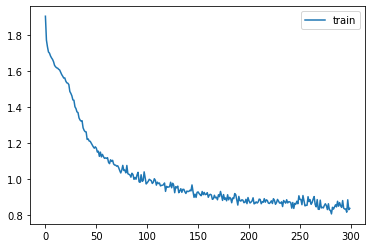

In [87]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 6


/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          B3    0.71053   0.61364   0.65854        44
          B2    0.75510   0.35238   0.48052       105
          B1    0.63366   0.50394   0.56140       127
          B0    0.77990   0.80296   0.79126       203
          S0    0.80932   0.79253   0.80084       241
          S1    0.60000   0.42254   0.49587       142
          S2    0.65517   0.37624   0.47799       101
          S3    1.00000   0.37838   0.54902        37

   micro avg    0.73789   0.59400   0.65817      1000
   macro avg    0.74296   0.53032   0.60193      1000
weighted avg    0.73276   0.59400   0.64336      1000
 samples avg    0.59400   0.59400   0.59400      1000

Confusion matrix, without normalization
[[ 38   5   1   0   0   0   0   0]
 [ 48  37  18   1   1   0   0   0]
 [ 35   7  64  21   0   0   0   0]
 [ 19   0  18 163   3   0   0   0]
 [ 23   0   0  22 191   5   0   0]
 [ 32   0   0   2  39  60   9   0]
 [ 29   0   0   0   2  32  38   0]
 [  9   0 

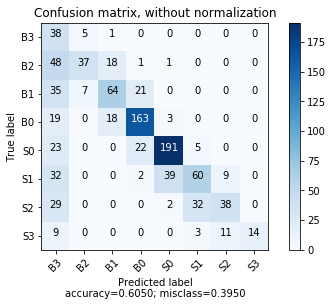

[3, 2, 1, 4, 4, 4, 0, 2, 2, 4, 1, 3, 1, 3, 6, 0, 3, 4, 3, 2, 3, 2, 3, 2, 4, 3, 3, 4, 3, 5, 4, 3, 4, 6, 3, 4, 3, 4, 6, 4, 4, 3, 6, 4, 5, 6, 4, 4, 6, 4, 6, 1, 3, 0, 2, 4, 4, 5, 4, 3, 3, 3, 3, 3, 4, 5, 2, 3, 6, 3, 6, 3, 3, 1, 1, 5, 4, 2, 0, 4, 3, 2, 3, 4, 3, 6, 5, 5, 4, 5, 2, 5, 2, 3, 1, 4, 5, 6, 3, 2, 1, 3, 0, 3, 7, 3, 5, 4, 6, 4, 6, 4, 3, 1, 3, 3, 6, 3, 3, 5, 6, 5, 4, 3, 1, 4, 1, 4, 3, 3, 1, 6, 0, 2, 3, 2, 7, 6, 2, 2, 5, 1, 2, 5, 3, 5, 4, 3, 4, 3, 1, 2, 4, 5, 4, 3, 7, 4, 3, 2, 3, 3, 4, 3, 3, 5, 4, 6, 3, 2, 3, 5, 6, 6, 6, 3, 4, 4, 3, 5, 4, 4, 3, 4, 2, 0, 0, 5, 6, 3, 3, 4, 3, 4, 5, 4, 3, 5, 1, 2, 2, 2, 4, 4, 4, 3, 3, 3, 5, 3, 4, 3, 4, 3, 3, 0, 0, 5, 4, 3, 3, 4, 5, 0, 5, 5, 6, 4, 2, 2, 4, 3, 6, 3, 2, 4, 5, 3, 3, 6, 3, 3, 4, 2, 6, 3, 5, 4, 3, 6, 6, 3, 0, 4, 2, 3, 1, 3, 1, 3, 1, 2, 5, 3, 4, 3, 4, 3, 3, 2, 0, 3, 4, 2, 6, 6, 4, 6, 0, 5, 2, 5, 3, 2, 2, 3, 4, 4, 6, 4, 2, 5, 1, 3, 1, 1, 0, 1, 3, 3, 2, 5, 3, 4, 3, 6, 5, 5, 5, 6, 0, 4, 3, 2, 3, 0, 1, 5, 1, 3, 1, 4, 3, 3, 4, 3, 6, 6, 5, 5, 3, 3, 3, 

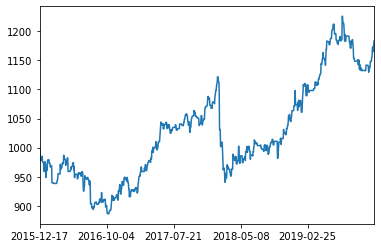

In [88]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 6s 1ms/step - loss: 1.9231 - accuracy: 0.2262
Epoch 2/300
3996/3996 [==============================] - 2s 426us/step - loss: 1.7404 - accuracy: 0.2785
Epoch 3/300
3996/3996 [==============================] - 2s 401us/step - loss: 1.7092 - accuracy: 0.2920
Epoch 4/300
3996/3996 [==============================] - 2s 459us/step - loss: 1.6826 - accuracy: 0.2878
Epoch 5/300
3996/3996 [==============================] - 2s 438us/step - loss: 1.6682 - accuracy: 0.29450s - loss: 1.6672 - accu
Epoch 6/300
3996/3996 [==============================] - 2s 492us/step - loss: 1.6475 - accuracy: 0.3026
Epoch 7/300
3996/3996 [==============================] - 2s 442us/step - loss: 1.6392 - accuracy: 0.3128
Epoch 8/300
3996/3996 [==============================] - 2s 474us/step - loss: 1.6171 - accuracy: 0.31330s - loss: 1.6171 - accu
Epoch 9/300
3996/3996 [==============================] - 2s 566us/step - loss: 1.6073 - accuracy: 0.32410s - loss:

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 431us/step - loss: 1.4165 - accuracy: 0.3959
Epoch 41/300
3996/3996 [==============================] - 2s 489us/step - loss: 1.4086 - accuracy: 0.4067
Epoch 42/300
3996/3996 [==============================] - 2s 418us/step - loss: 1.4151 - accuracy: 0.3881
Epoch 43/300
3996/3996 [==============================] - 2s 462us/step - loss: 1.4086 - accuracy: 0.4024
Epoch 44/300
3996/3996 [==============================] - 2s 489us/step - loss: 1.4091 - accuracy: 0.4027
Epoch 45/300
3996/3996 [==============================] - 2s 539us/step - loss: 1.3962 - accuracy: 0.4022
Epoch 46/300
3996/3996 [==============================] - 2s 530us/step - loss: 1.4011 - accuracy: 0.3971
Epoch 47/300
1888/3996 [=============>................] - ETA: 1s - loss: 1.3983 - accuracy: 0.4094

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)